현재 데이터셋은 delta_t 값이 너무커서, 원본데이터의 time derivative 값이 매우 부정확한 문제가 있음.

autoencoder로 low-dimensional z를 먼저생성하고, 
만약 z의 trajectory가 smooth하다면, time derivative 값을 정확하게 계산할 수 있을 듯 함.


In [302]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
import warnings
import torch
import torch.nn as nn
import sys
import pysindy as ps
from torch.utils.data import Dataset, DataLoader, TensorDataset


sindy_path = '/home/sihoon/works/HAVOK/SindyPendulum_main/src'
if sindy_path not in sys.path:
    sys.path.insert(0, sindy_path)
from sindy_library import SINDyLibrary

np.random.seed(34)
warnings.filterwarnings('ignore')

# Get cpu or gpu device for training.
print(f'torch.cuda.is_available():{torch.cuda.is_available()}')
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

torch.cuda.is_available():True
Using cuda device


Data preparation

In [213]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names


dataset_path = './Dataset/CMaps'

dftrain = pd.read_csv(os.path.join(dataset_path, 'train_FD001.txt'),sep='\s+',header=None,index_col=False,names=col_names)
dfvalid = pd.read_csv(os.path.join(dataset_path, 'test_FD001.txt'),sep='\s+',header=None,index_col=False,names=col_names)
y_valid = pd.read_csv(os.path.join(dataset_path, 'RUL_FD001.txt'),sep='\s+',header=None,index_col=False,names=['RUL'])
dfvalid.shape

train = dftrain.copy()
valid = dfvalid.copy()

print('Shape of the train dataset : ',train.shape)
print('Shape of the validation dataset : ',valid.shape)
print('Percentage of the validation dataset : ',len(valid)/(len(valid)+len(train)))

Shape of the train dataset :  (20631, 26)
Shape of the validation dataset :  (13096, 26)
Percentage of the validation dataset :  0.3882942449669404


In [16]:
#Cheking the presence of Nan values 
print('Total None values in the train dataset : ',train.isna().sum())

Total None values in the train dataset :  unit_number    0
time_cycles    0
setting_1      0
setting_2      0
setting_3      0
s_1            0
s_2            0
s_3            0
s_4            0
s_5            0
s_6            0
s_7            0
s_8            0
s_9            0
s_10           0
s_11           0
s_12           0
s_13           0
s_14           0
s_15           0
s_16           0
s_17           0
s_18           0
s_19           0
s_20           0
s_21           0
dtype: int64


In [18]:
train.loc[:, ['unit_number', 'time_cycles']].describe()

unit_number   time_cycles
count  20631.000000  20631.000000
mean      51.506568    108.807862
std       29.227633     68.880990
min        1.000000      1.000000
25%       26.000000     52.000000
50%       52.000000    104.000000
75%       77.000000    156.000000
max      100.000000    362.000000

In [20]:
train.loc[:,'s_1':].describe().transpose()


count         mean           std        min        25%        50%  \
s_1   20631.0   518.670000  6.537152e-11   518.6700   518.6700   518.6700   
s_2   20631.0   642.680934  5.000533e-01   641.2100   642.3250   642.6400   
s_3   20631.0  1590.523119  6.131150e+00  1571.0400  1586.2600  1590.1000   
s_4   20631.0  1408.933782  9.000605e+00  1382.2500  1402.3600  1408.0400   
s_5   20631.0    14.620000  3.394700e-12    14.6200    14.6200    14.6200   
s_6   20631.0    21.609803  1.388985e-03    21.6000    21.6100    21.6100   
s_7   20631.0   553.367711  8.850923e-01   549.8500   552.8100   553.4400   
s_8   20631.0  2388.096652  7.098548e-02  2387.9000  2388.0500  2388.0900   
s_9   20631.0  9065.242941  2.208288e+01  9021.7300  9053.1000  9060.6600   
s_10  20631.0     1.300000  4.660829e-13     1.3000     1.3000     1.3000   
s_11  20631.0    47.541168  2.670874e-01    46.8500    47.3500    47.5100   
s_12  20631.0   521.413470  7.375534e-01   518.6900   520.9600   521.4800   
s_13  20631.0  2388.096152  7.191892e-02  2387.8800  2388.0400  2388.0900   
s_14  20631.0  8143.752722  1.907618e+01  8099.9400  8133.2450  8140.5400   
s_15  20631.0     8.442146  3.750504e-02     8.3249     8.4149     8.4389   
s_16  20631.0     0.030000  1.556432e-14     0.0300     0.0300     0.0300   
s_17  20631.0   393.210654  1.548763e+00   388.0000   392.0000   393.0000   
s_18  20631.0  2388.000000  0.000000e+00  2388.0000  2388.0000  2388.0000   
s_19  20631.0   100.000000  0.000000e+00   100.0000   100.0000   100.0000   
s_20  20631.0    38.816271  1.807464e-01    38.1400    38.7000    38.8300   
s_21  20631.0    23.289705  1.082509e-01    22.8942    23.2218    23.2979   

            75%        max  
s_1    518.6700   518.6700  
s_2    643.0000   644.5300  
s_3   1594.3800  1616.9100  
s_4   1414.5550  1441.4900  
s_5     14.6200    14.6200  
s_6     21.6100    21.6100  
s_7    554.0100   556.0600  
s_8   2388.1400  2388.5600  
s_9   9069.4200  9244.5900  
s_10     1.3000     1.3000  
s_11    47.7000    48.5300  
s_12   521.9500   523.3800  
s_13  2388.1400  2388.5600  
s_14  8148.3100  8293.7200  
s_15     8.4656     8.5848  
s_16     0.0300     0.0300  
s_17   394.0000   400.0000  
s_18  2388.0000  2388.0000  
s_19   100.0000   100.0000  
s_20    38.9500    39.4300  
s_21    23.3668    23.6184

Max time cycle found for each unit

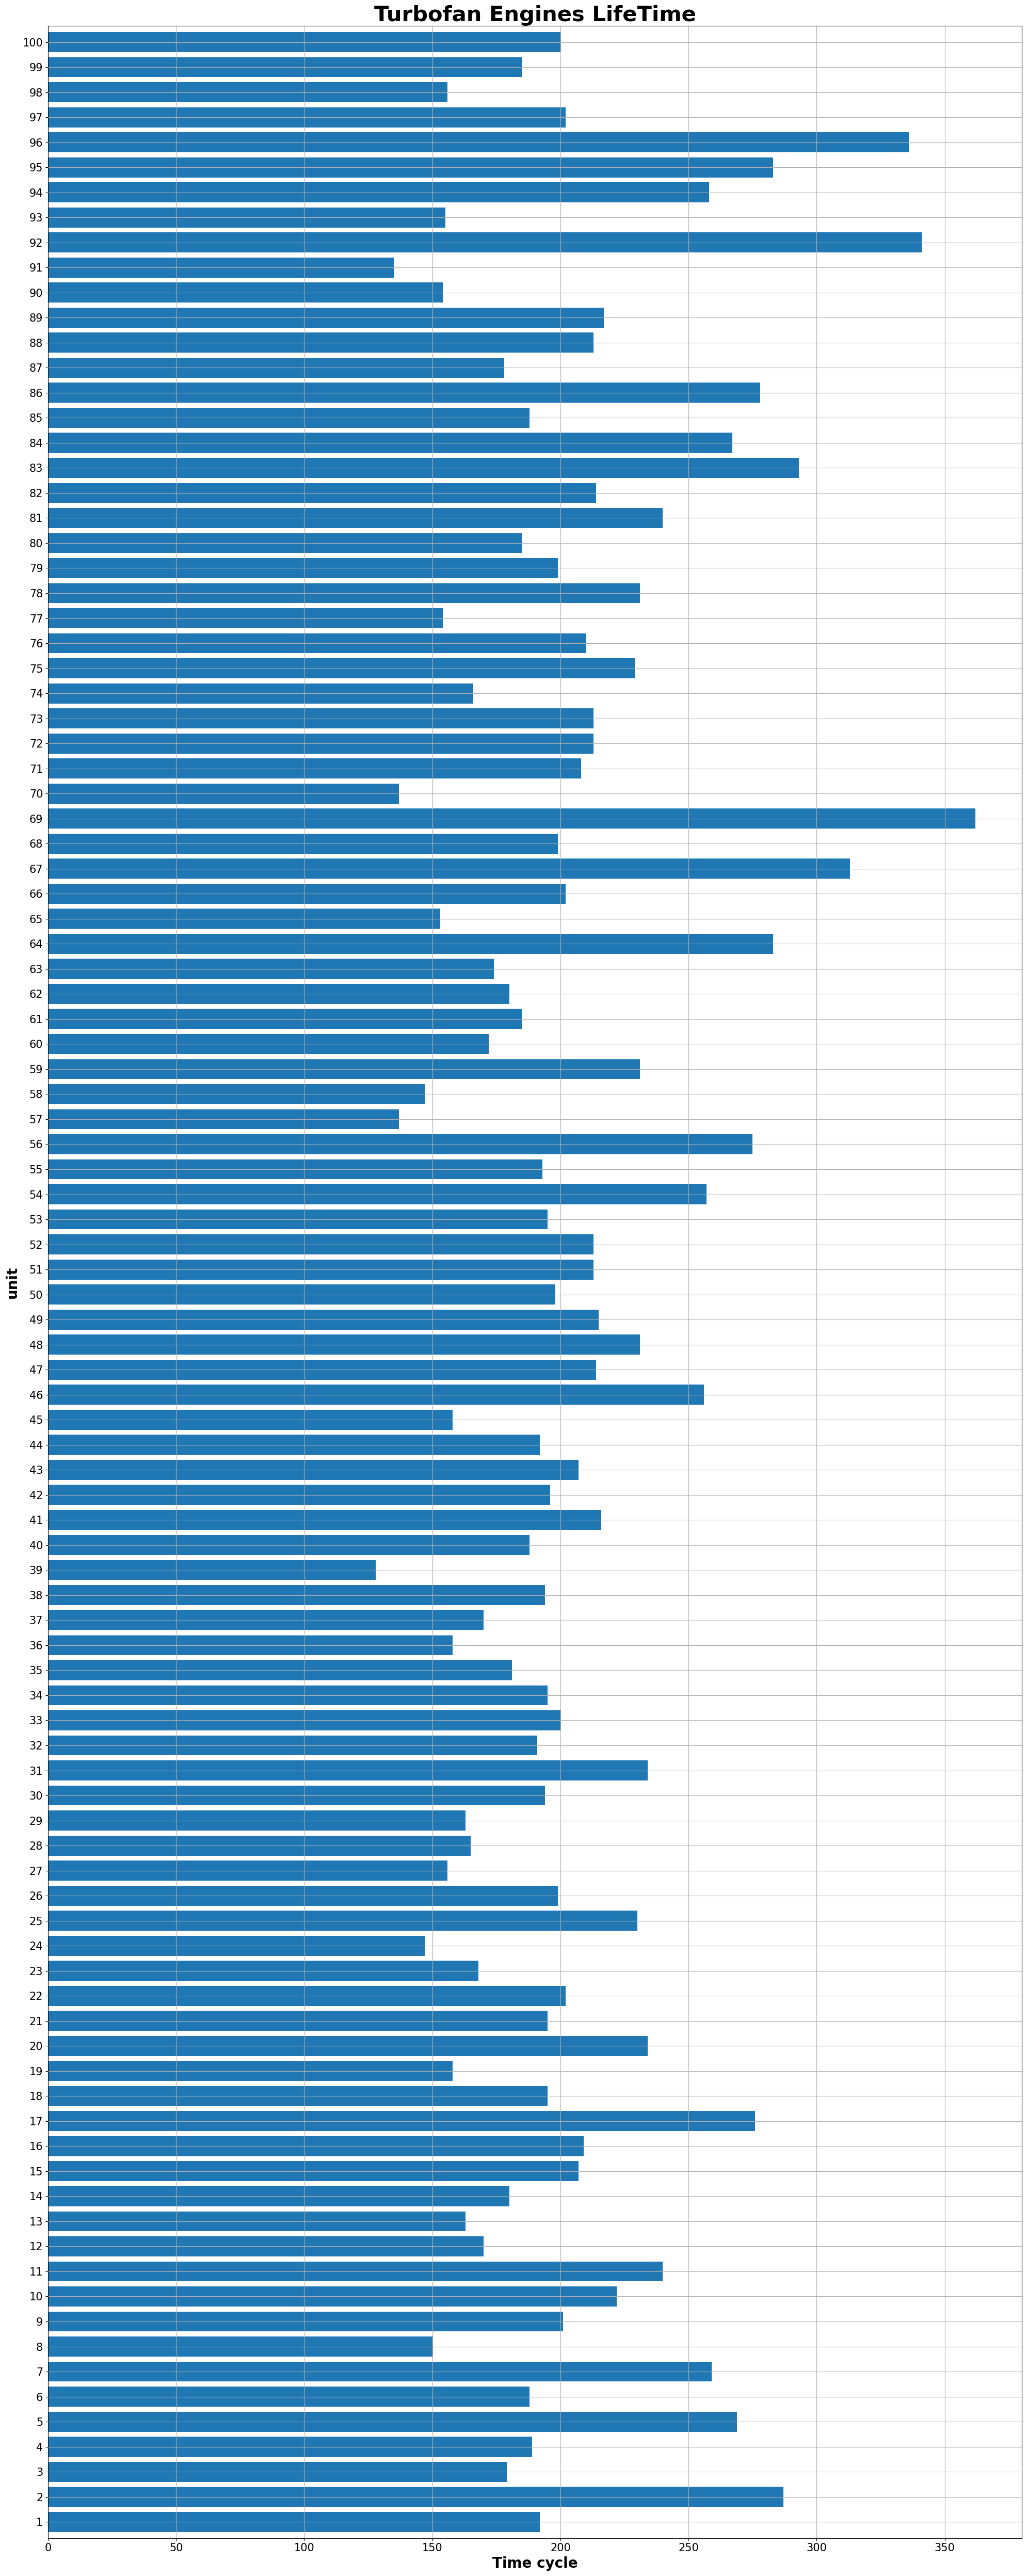

In [24]:
max_time_cycles=train[index_names].groupby('unit_number').max()
max_time_cycles
plt.figure(figsize=(20,50))
ax=max_time_cycles['time_cycles'].plot(kind='barh',width=0.8, stacked=True,align='center')
plt.title('Turbofan Engines LifeTime',fontweight='bold',size=30)
plt.xlabel('Time cycle',fontweight='bold',size=20)
plt.xticks(size=15)
plt.ylabel('unit',fontweight='bold',size=20)
plt.yticks(size=15)
plt.grid(True)
plt.tight_layout()
plt.show()

Text(0.5, 9.444444444444459, 'max time cycle')

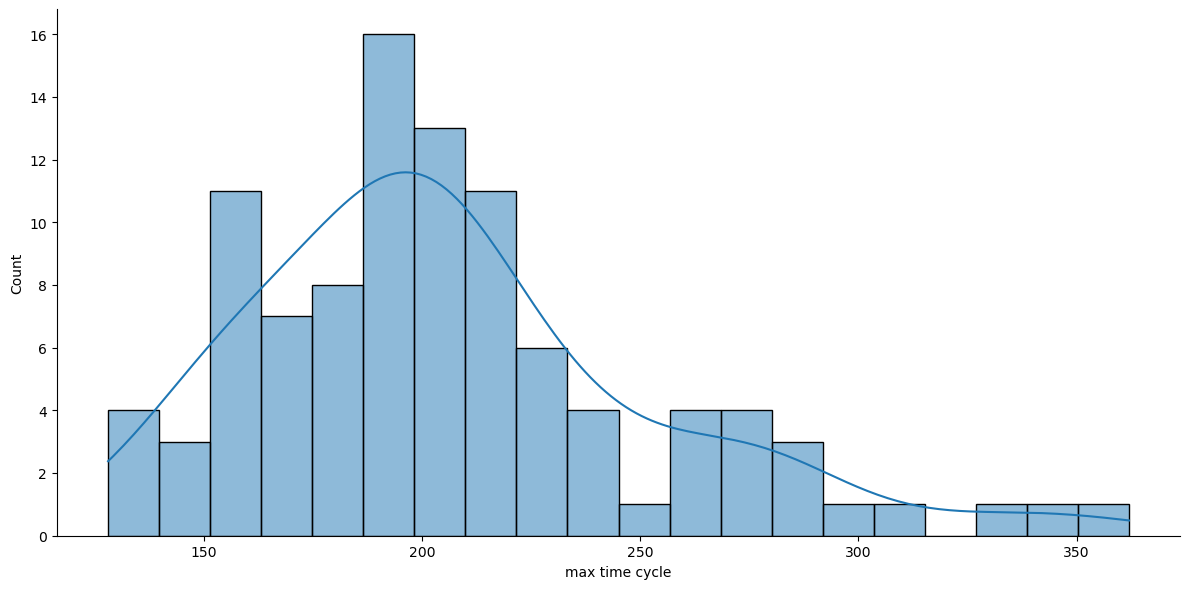

In [25]:
#Distribution of maximum time cycles
sns.displot(max_time_cycles['time_cycles'],kde=True,bins=20,height=6,aspect=2)
plt.xlabel('max time cycle')

Add RUL comun to the data
RUL corresponds to the remining time cycles for each unit before it fails

In [214]:
def add_RUL_column(df):
    '''
    RUL: for each unit_number, 'max_time_cycles' denotes end of the life time.
        Thus, RUL = 'max_time_cycles' - each currnet time 'time_cycles'
    '''
    train_grouped_by_unit = df.groupby(by='unit_number') 
    max_time_cycles = train_grouped_by_unit['time_cycles'].max() 
    # print(max_time_cycles)
    # print(max_time_cycles.to_frame(name='max_time_cycle'))
    merged = df.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='unit_number',right_index=True)
    # print(merged[['unit_number', 'max_time_cycle', 'time_cycles']])
    merged["RUL"] = merged["max_time_cycle"] - merged['time_cycles']
    merged = merged.drop("max_time_cycle", axis=1) 
    return merged

In [215]:
train = add_RUL_column(train)
train[['unit_number','RUL']]

unit_number  RUL
0                1  191
1                1  190
2                1  189
3                1  188
4                1  187
...            ...  ...
20626          100    4
20627          100    3
20628          100    2
20629          100    1
20630          100    0

[20631 rows x 2 columns]

In [50]:
#Rul analysis
maxrul_u = train.groupby('unit_number').max().reset_index()
maxrul_u.head()

unit_number  time_cycles  setting_1  setting_2  setting_3     s_1     s_2  \
0            1          192     0.0047     0.0005      100.0  518.67  644.21   
1            2          287     0.0076     0.0006      100.0  518.67  643.94   
2            3          179     0.0058     0.0005      100.0  518.67  643.93   
3            4          189     0.0059     0.0006      100.0  518.67  644.53   
4            5          269     0.0055     0.0005      100.0  518.67  644.02   

       s_3      s_4    s_5  ...     s_13     s_14    s_15  s_16  s_17  s_18  \
0  1605.44  1432.52  14.62  ...  2388.35  8140.58  8.5227  0.03   398  2388   
1  1610.10  1431.17  14.62  ...  2388.26  8175.57  8.5377  0.03   398  2388   
2  1606.50  1438.51  14.62  ...  2388.20  8255.34  8.5363  0.03   399  2388   
3  1612.11  1434.12  14.62  ...  2388.17  8259.42  8.5462  0.03   399  2388   
4  1609.41  1434.59  14.62  ...  2388.23  8215.19  8.5410  0.03   398  2388   

    s_19   s_20     s_21  RUL  
0  100.0  39.18  23.4999  191  
1  100.0  39.24  23.6005  286  
2  100.0  39.23  23.5181  178  
3  100.0  39.21  23.5074  188  
4  100.0  39.29  23.5503  268  

[5 rows x 27 columns]

Discoverning Correltations


             unit_number  time_cycles  setting_1  setting_2  setting_3  s_1  \
unit_number     1.000000     0.078753  -0.017895  -0.006197        NaN  NaN   
time_cycles     0.078753     1.000000  -0.004527   0.016132        NaN  NaN   
setting_1      -0.017895    -0.004527   1.000000   0.011660        NaN  NaN   
setting_2      -0.006197     0.016132   0.011660   1.000000        NaN  NaN   
setting_3            NaN          NaN        NaN        NaN        NaN  NaN   
s_1                  NaN          NaN        NaN        NaN        NaN  NaN   
s_2             0.014133     0.549898   0.009030   0.007266        NaN  NaN   
s_3             0.012621     0.543947  -0.005651   0.009068        NaN  NaN   
s_4             0.026116     0.624577   0.009544   0.014673        NaN  NaN   
s_5                  NaN          NaN        NaN        NaN        NaN  NaN   
s_6             0.026431     0.105980  -0.001340   0.014355        NaN  NaN   
s_7            -0.032073    -0.595914  -0.009437  -0

<Axes: >

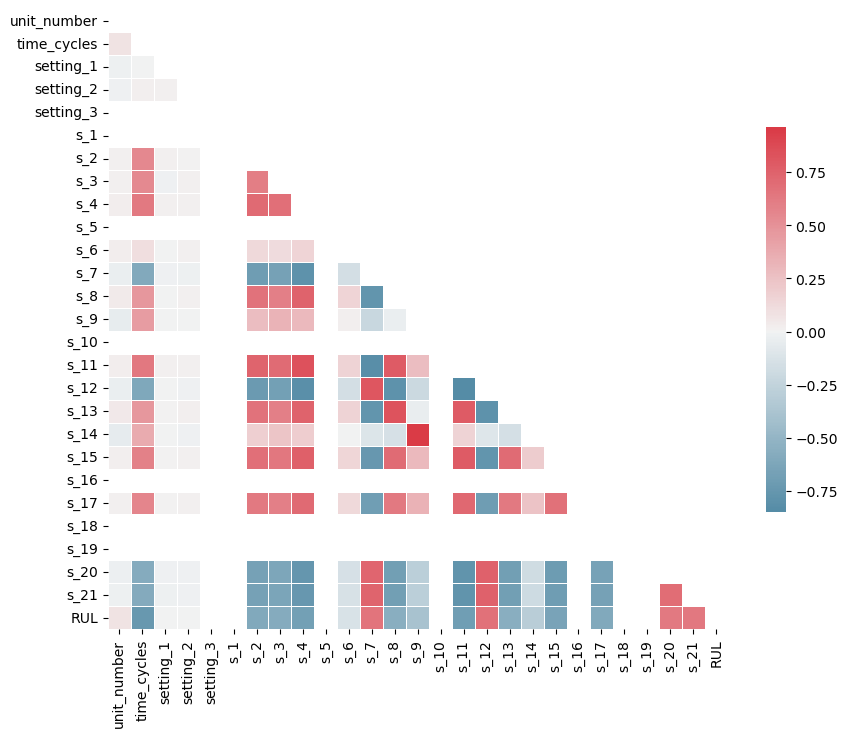

In [216]:
# Compute the correlation matrix
corr = train.corr() # 두 열 간의 상관 계수를 반환함
# 피어슨 상관계수: 
# 1: 두 변수 간 양의 선형 상관 관계, x가 증가하면 y도 증가함.
# -1: 음의 선형 상관 관계, x가 증가하면 y는 감소함.
# 0: 선형 상관관계가 없음
print(corr)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(230, 10, as_cmap=True) # maybe color
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

Plotting the evolution of features (sensors) along with the evolution with RUL

In [217]:
Sensor_dictionary={}
dict_list=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
i=1
for x in dict_list :
    Sensor_dictionary['s_'+str(i)]=x
    i+=1
Sensor_dictionary

{'s_1': '(Fan inlet temperature) (◦R)',
 's_2': '(LPC outlet temperature) (◦R)',
 's_3': '(HPC outlet temperature) (◦R)',
 's_4': '(LPT outlet temperature) (◦R)',
 's_5': '(Fan inlet Pressure) (psia)',
 's_6': '(bypass-duct pressure) (psia)',
 's_7': '(HPC outlet pressure) (psia)',
 's_8': '(Physical fan speed) (rpm)',
 's_9': '(Physical core speed) (rpm)',
 's_10': '(Engine pressure ratio(P50/P2)',
 's_11': '(HPC outlet Static pressure) (psia)',
 's_12': '(Ratio of fuel flow to Ps30) (pps/psia)',
 's_13': '(Corrected fan speed) (rpm)',
 's_14': '(Corrected core speed) (rpm)',
 's_15': '(Bypass Ratio) ',
 's_16': '(Burner fuel-air ratio)',
 's_17': '(Bleed Enthalpy)',
 's_18': '(Required fan speed)',
 's_19': '(Required fan conversion speed)',
 's_20': '(High-pressure turbines Cool air flow)',
 's_21': '(Low-pressure turbines Cool air flow)'}

In [218]:
def plot_signal(df, Sensor_dic, signal_name):
    plt.figure(figsize=(13,5))
    
    
    
    for i in df['unit_number'].unique():
        if (i % 10 == 0):   #For a better visualisation, we plot the sensors signals of 20 units only
            plt.plot('RUL', signal_name, data=df[df['unit_number']==i].rolling(10).mean())

    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 300, 25))
    plt.ylabel(Sensor_dic[signal_name])
    plt.xlabel('Remaining Useful Life')
    plt.show()

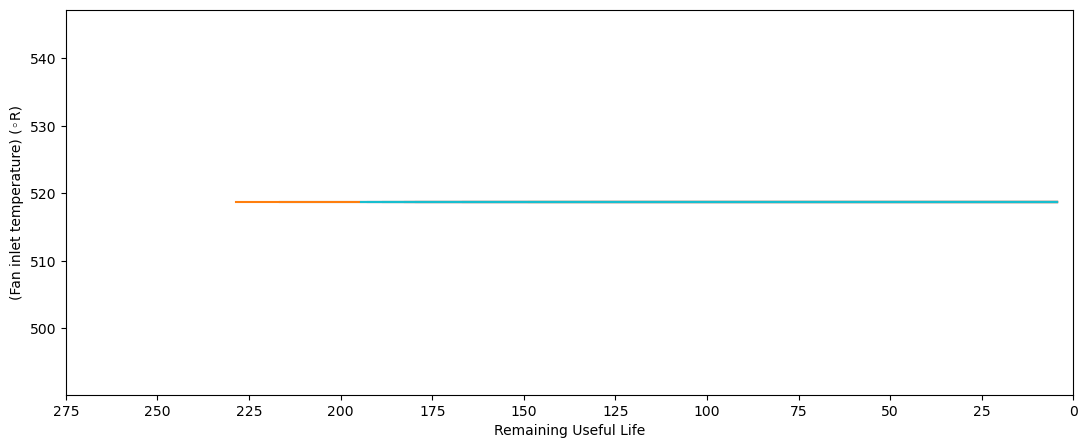

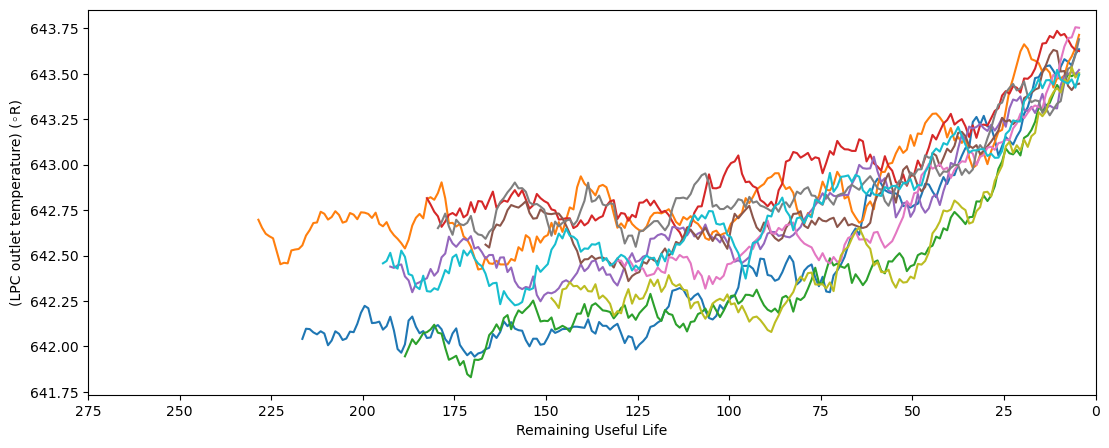

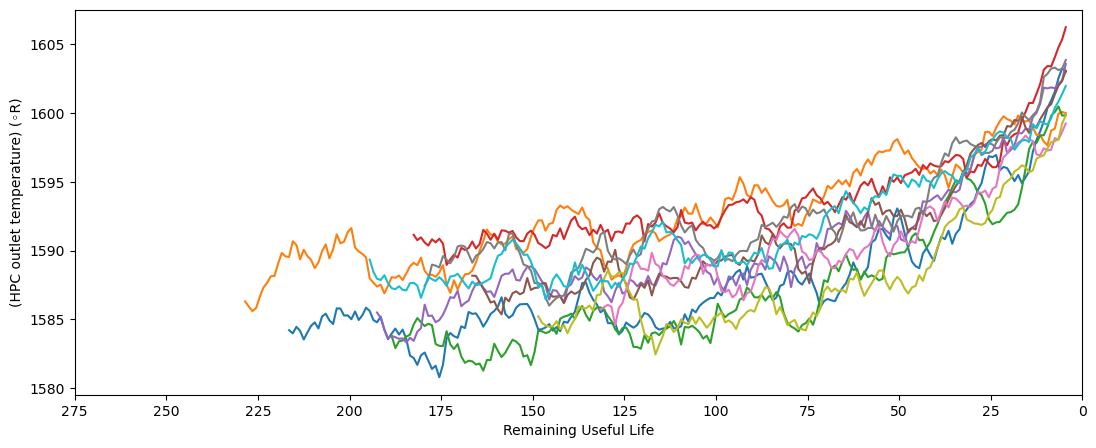

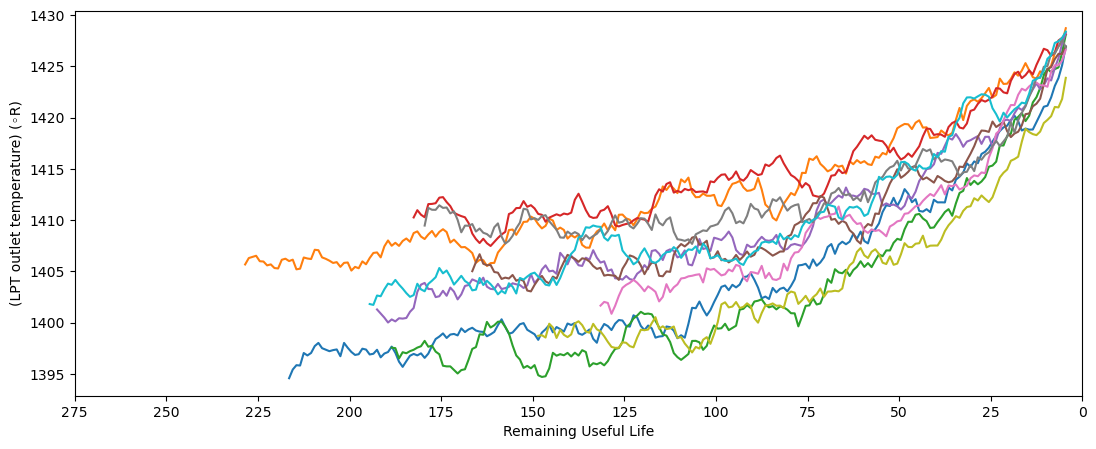

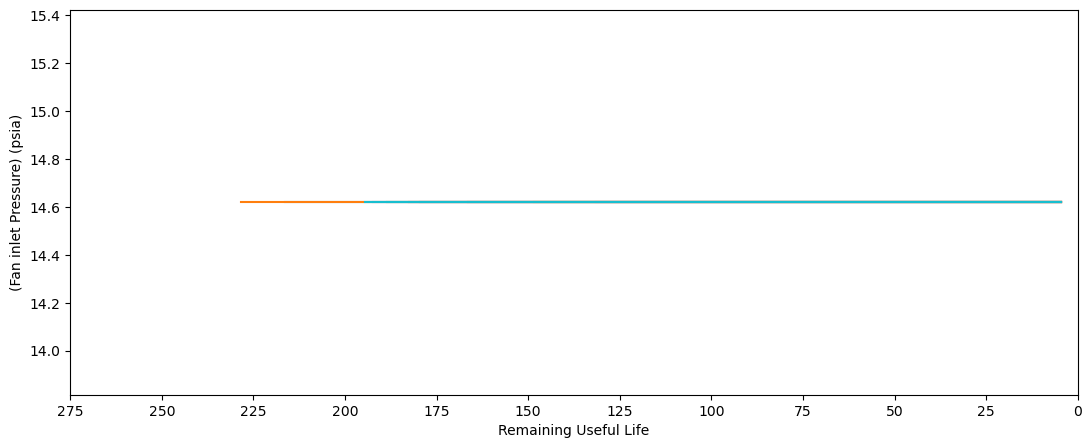

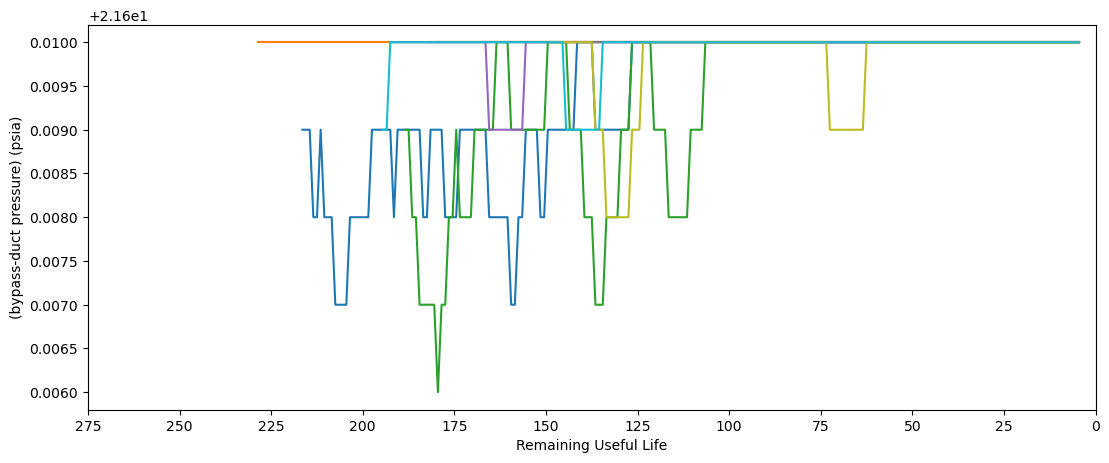

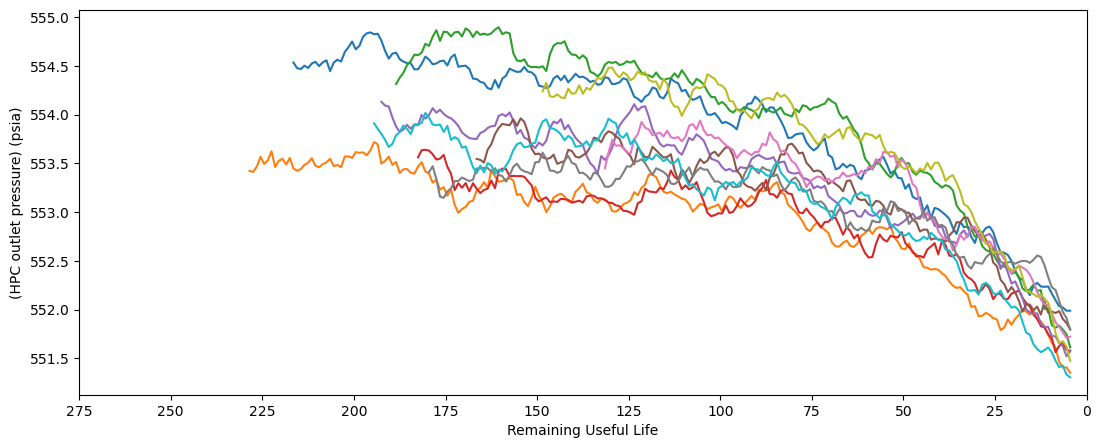

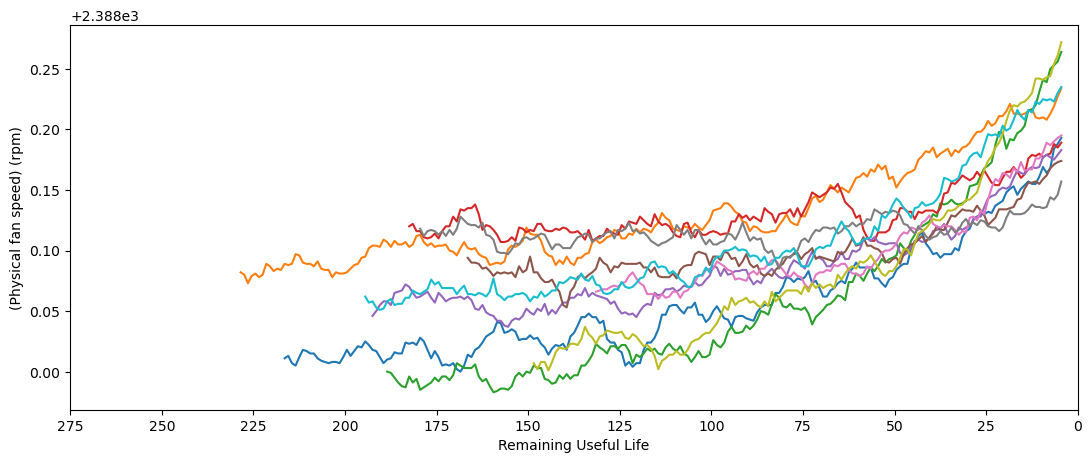

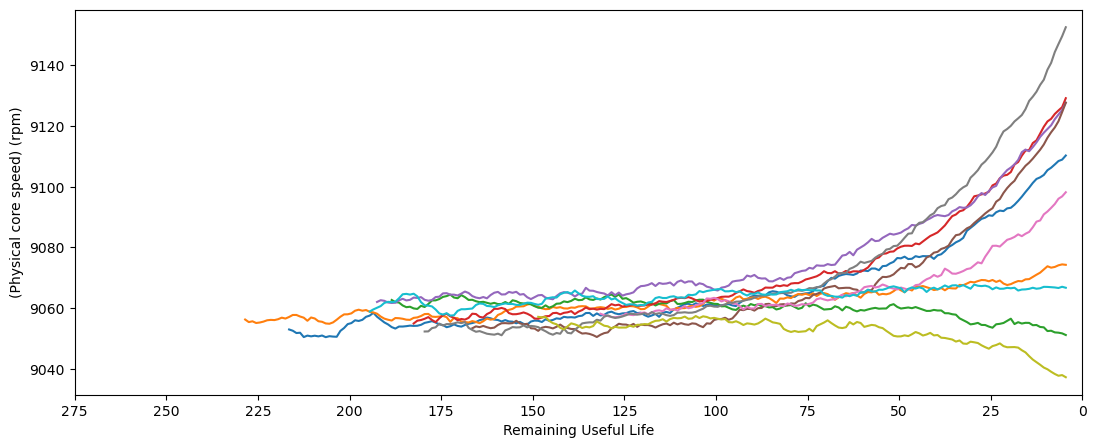

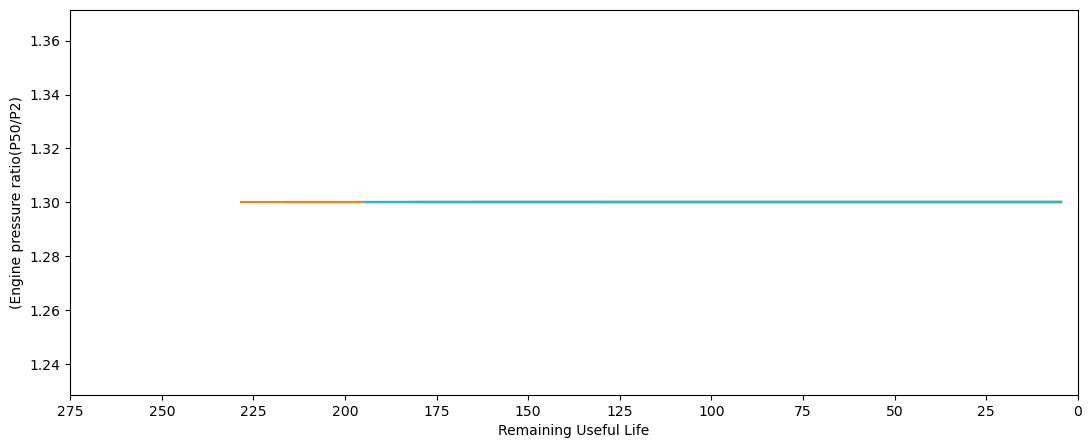

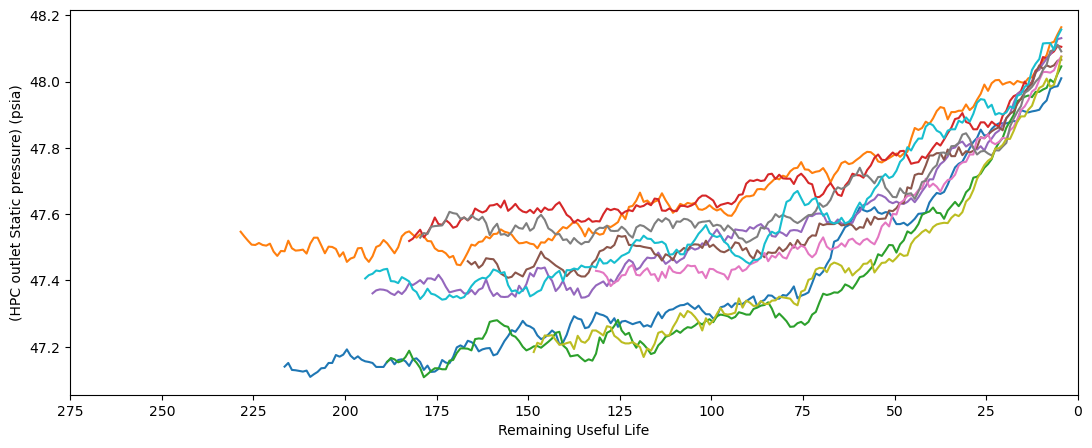

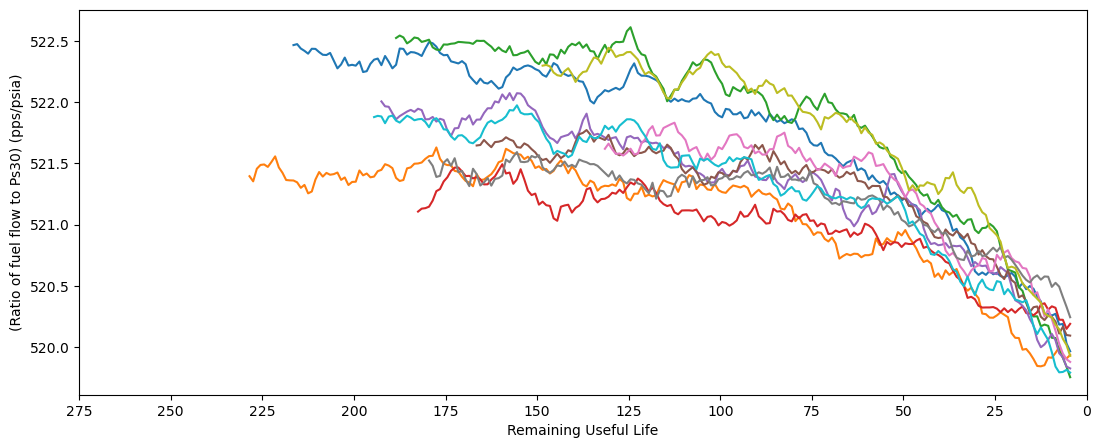

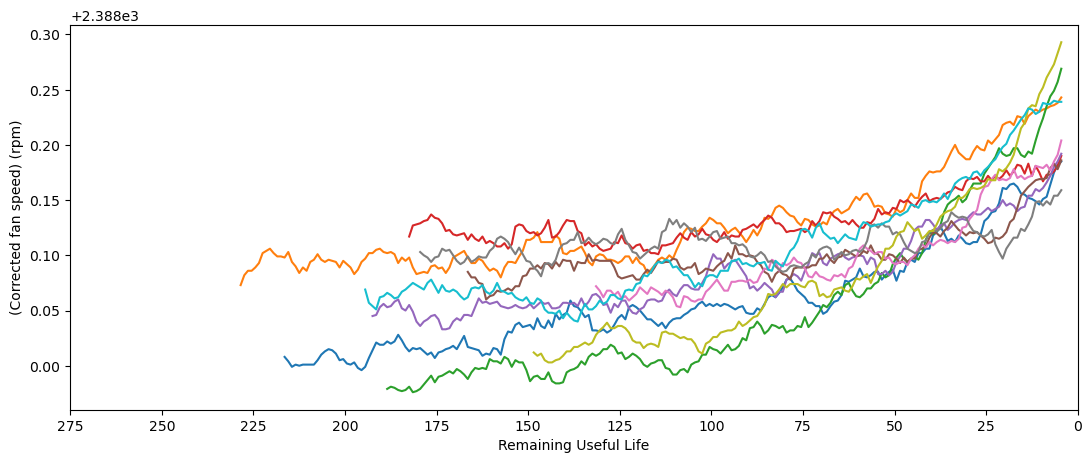

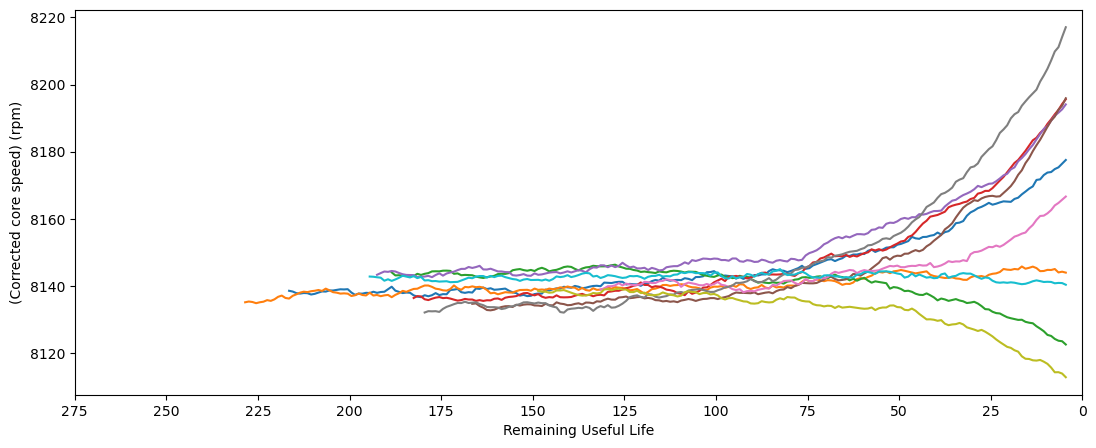

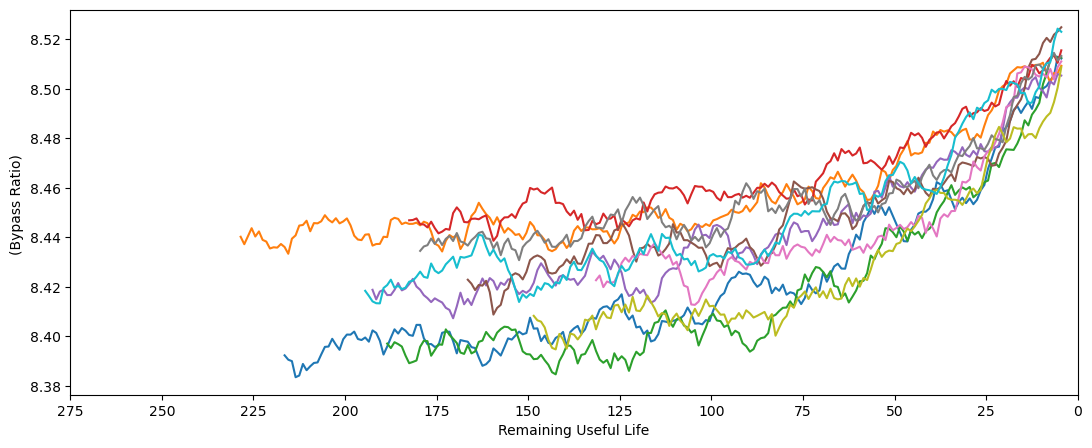

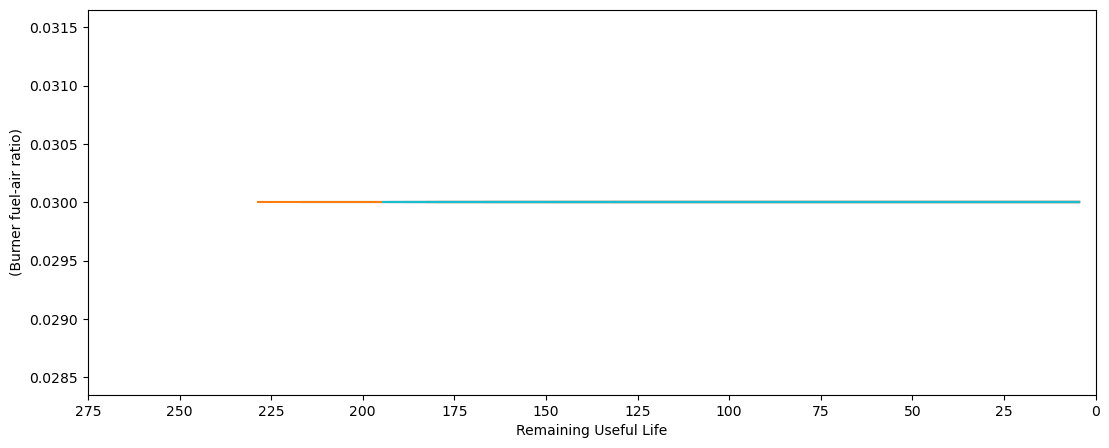

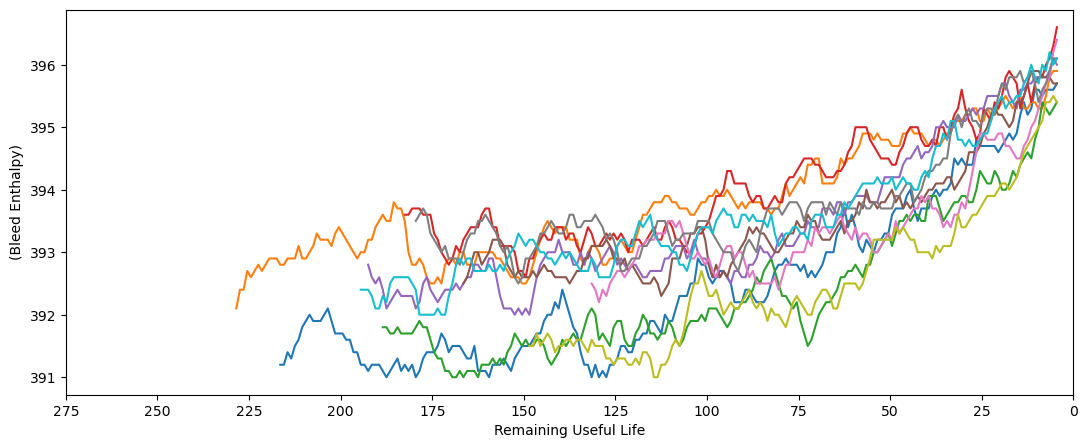

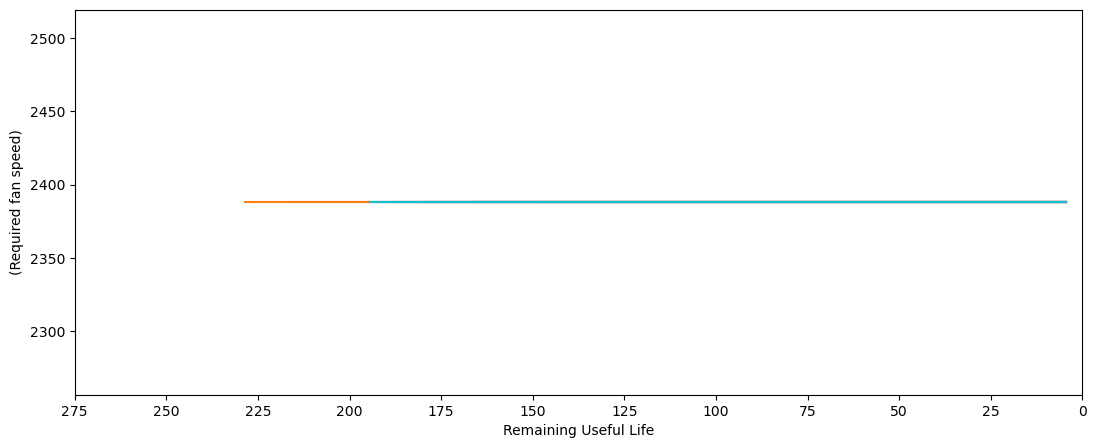

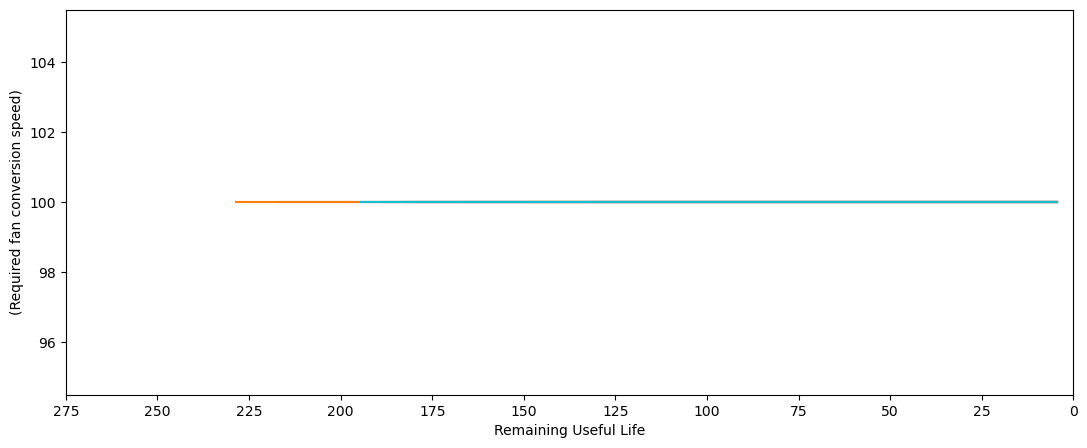

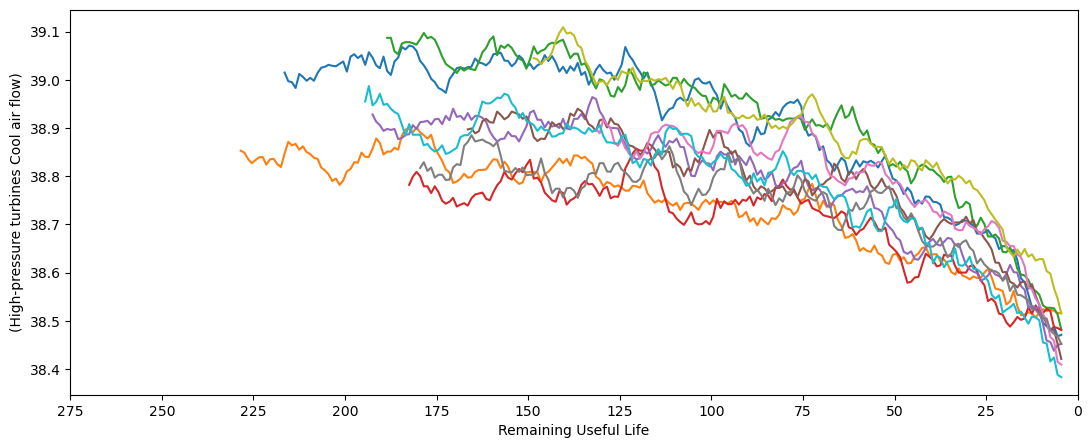

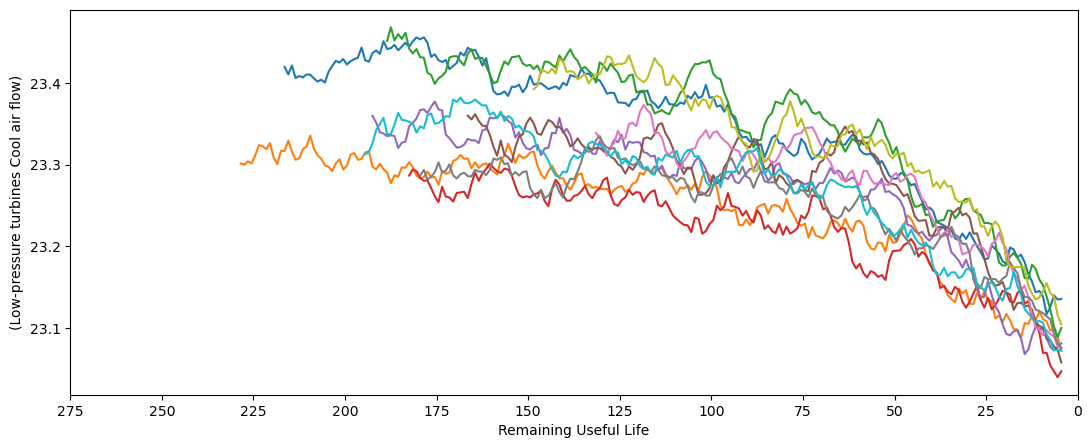

In [219]:
for i in range(1,22):
    try:
        plot_signal(train, Sensor_dictionary,'s_'+str(i))
    except:
        pass

In [92]:
train[train['unit_number']==1]['RUL'].rolling(10).mean()

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
      ... 
187    8.5
188    7.5
189    6.5
190    5.5
191    4.5
Name: RUL, Length: 192, dtype: float64

In [220]:
def subplot_signal(df, Sensor_dic):
    fig, axs = plt.subplots(7, 3,figsize=(18,30))
    
    
    for i, ax in enumerate(axs.flatten()):
        for j in df['unit_number'].unique():
            if (j % 10 == 0):   #For a better visualisation, we plot the sensors signals of 20 units only
                if i+1 in range(1, 22):
                    ax.plot('RUL', 's_'+str(i+1), data=df[df['unit_number']==j].rolling(10).mean())
                    ax.set_title('s_'+str(i+1))
                    ax.set_xlabel('RUL')
                    ax.set_xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
                    ax.set_xticks(np.arange(0, 300, 25))
    
    
    
    plt.tight_layout()
    plt.show()
    

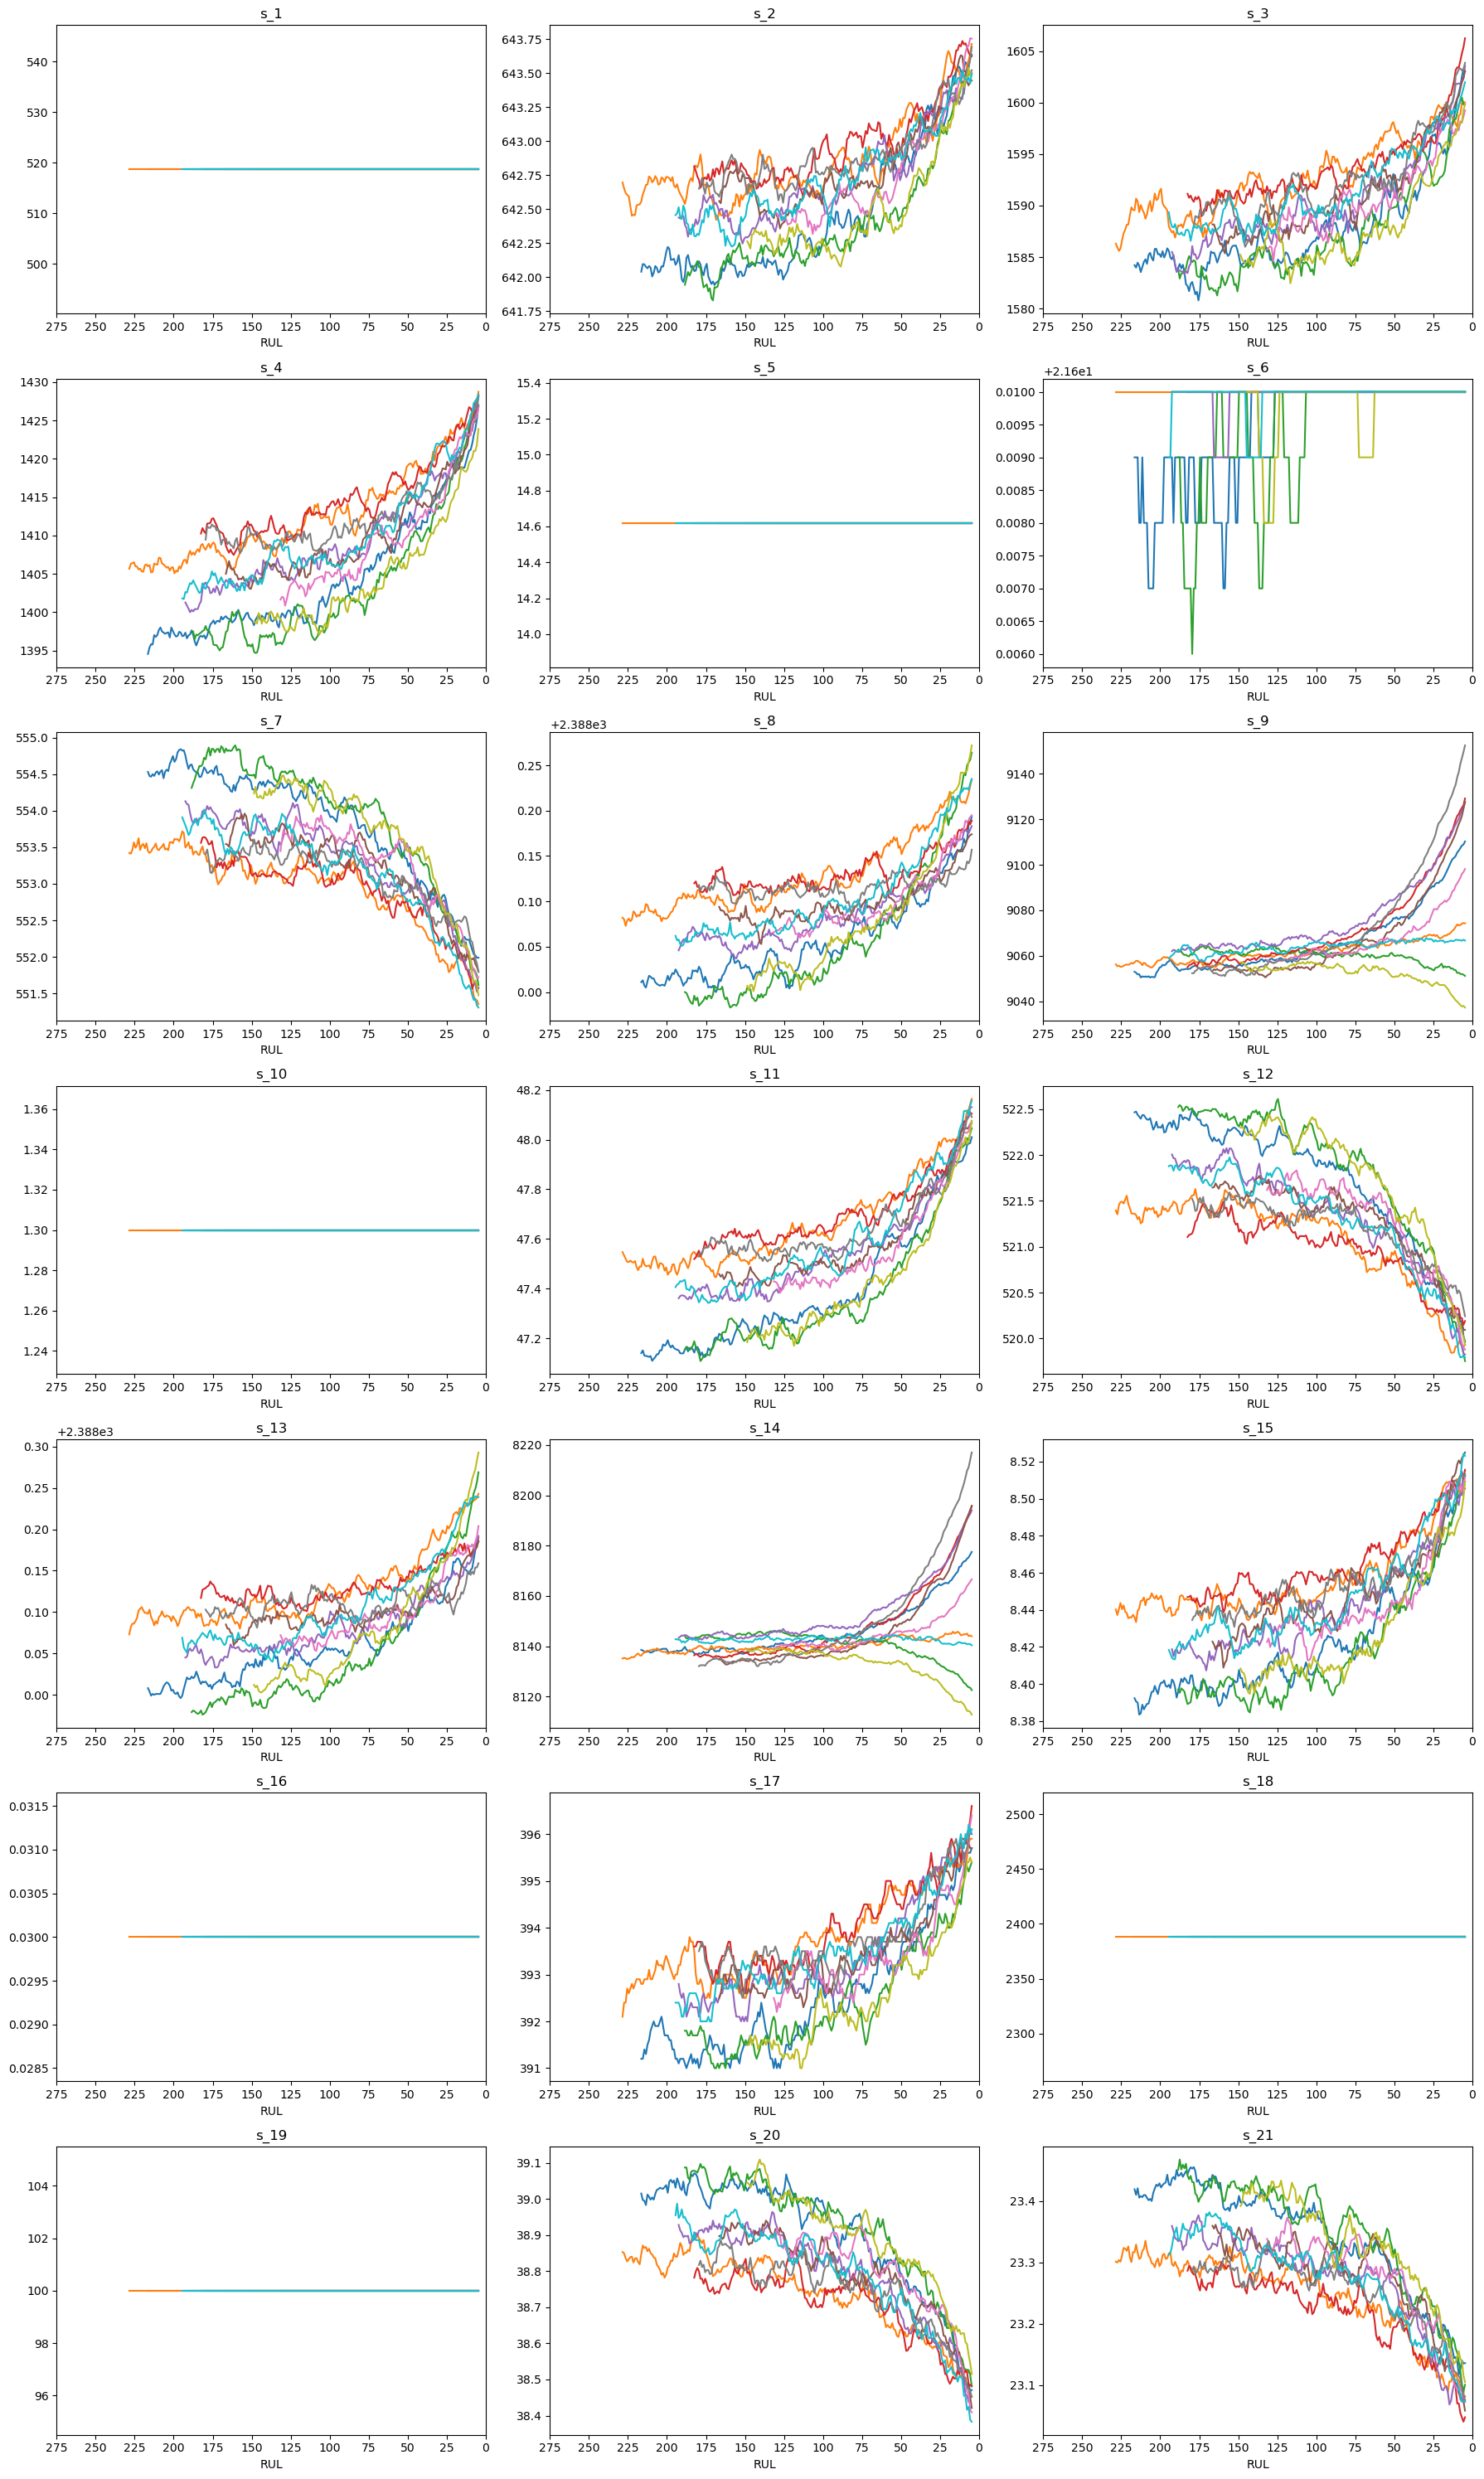

In [221]:
subplot_signal(train, Sensor_dictionary)


These plots show that some sensors are constant. Hence they don't influence the RUL ==> we can drop those ones. (later)

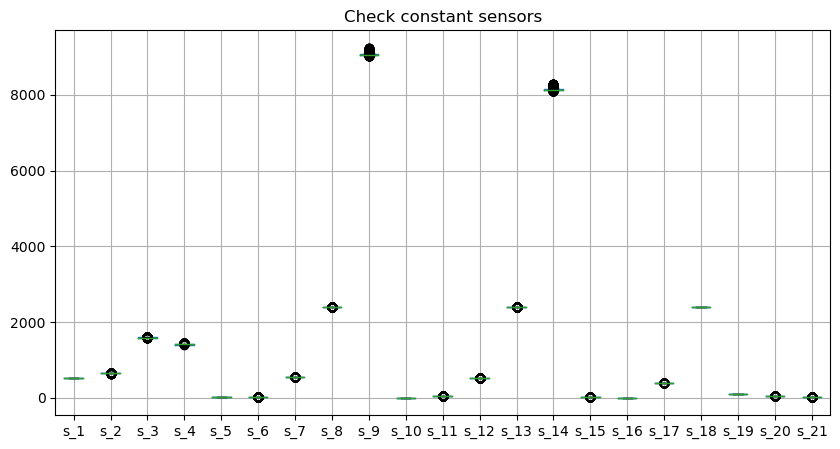

In [222]:
plt.figure(figsize=(10, 5))
train.boxplot(column=['s_'+str(i) for i in range(1,22)])
plt.title('Check constant sensors')
# plt.ylim(-0.5, 10)
plt.show()

Observing the signal plots and the boxplots, we notice that the sensors 1,5,10,16,18,19 are constant, furthermore, we observe that the other sensors aren't well distributed and there are many outliers, then we should scale our data

Dropping unnecessary features (labels and settings)

In [316]:
from sklearn.model_selection import train_test_split
drop_labels = index_names+setting_names
X_train=train.drop(columns=drop_labels).copy()
# print(X_train.shape)
# X_train, X_test, y_train, y_test=train_test_split(X_train,X_train['RUL'], test_size=0.3, random_state=42)
y_train = X_train['RUL'].copy()
# X_train columns: ['s_1', ..., 's_21', 'RUL']
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Scaling the data 


In [317]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#Droping the target variable
X_train.drop(columns=['RUL'], inplace=True) # (14441, 21)
# X_test.drop(columns=['RUL'], inplace=True)  # (6190, 21)

#Scaling X_train and X_test
X_train_s=scaler.fit_transform(X_train)
# X_test_s=scaler.fit_transform(X_test)

#Conserve only the last occurence of each unit to match the length of y_valid
# last row of valid df
X_valid = valid.groupby('unit_number').last().reset_index().drop(columns=drop_labels)   
#scaling X_valid
X_valid_s=scaler.fit_transform(X_valid)
# X_valid.columns : ['s_1', ..., 's_21']


In [274]:
print(X_valid_s.shape)
print(y_valid.shape)
print(X_train.shape)

(100, 21)
(100, 1)
(14441, 22)


Sensor trajectory figures under unit_number=1

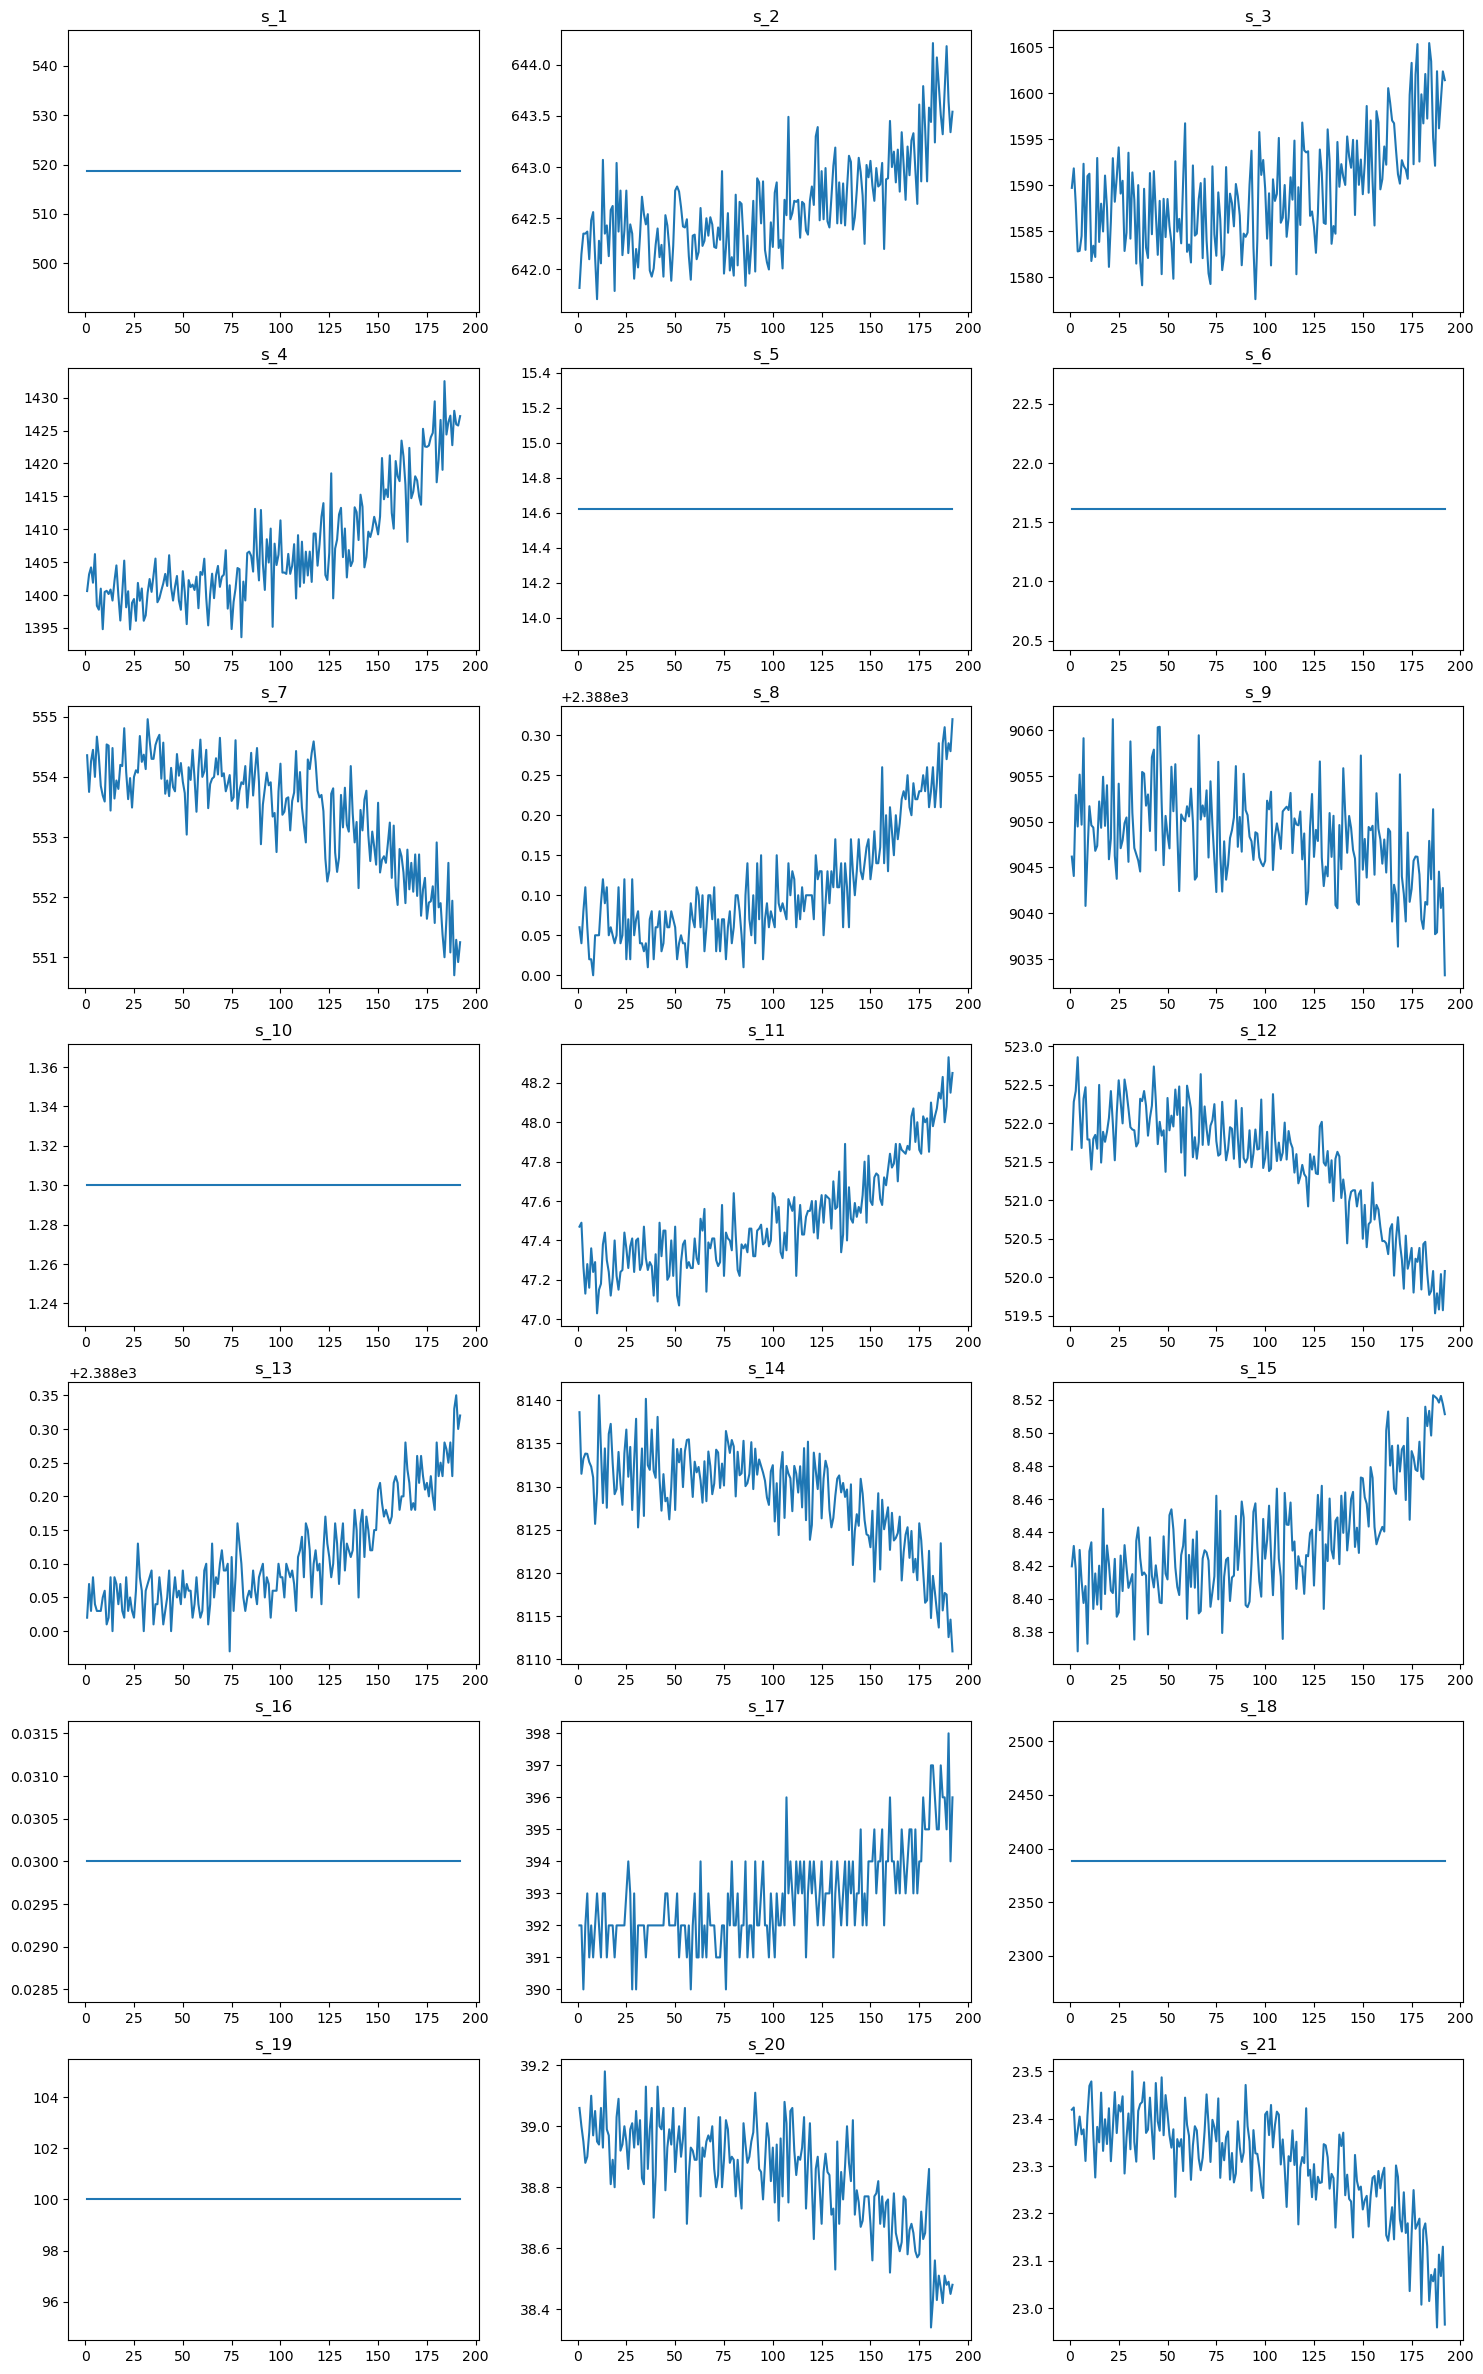

In [259]:
def show_sensor_traj(df):
    fig, axs = plt.subplots(7, 3,figsize=(18,30))
    
    for i in range(len(sensor_names)):
        ax = axs.ravel()[i]
        ax.plot('time_cycles', 's_'+str(i+1), data=df)
        ax.set_title('s_'+str(i+1))
        
    plt.show()
train_sensor = train[train['unit_number']==1]
show_sensor_traj(train_sensor)

rolling mean(10) 으로 완만하게 만들어보기...

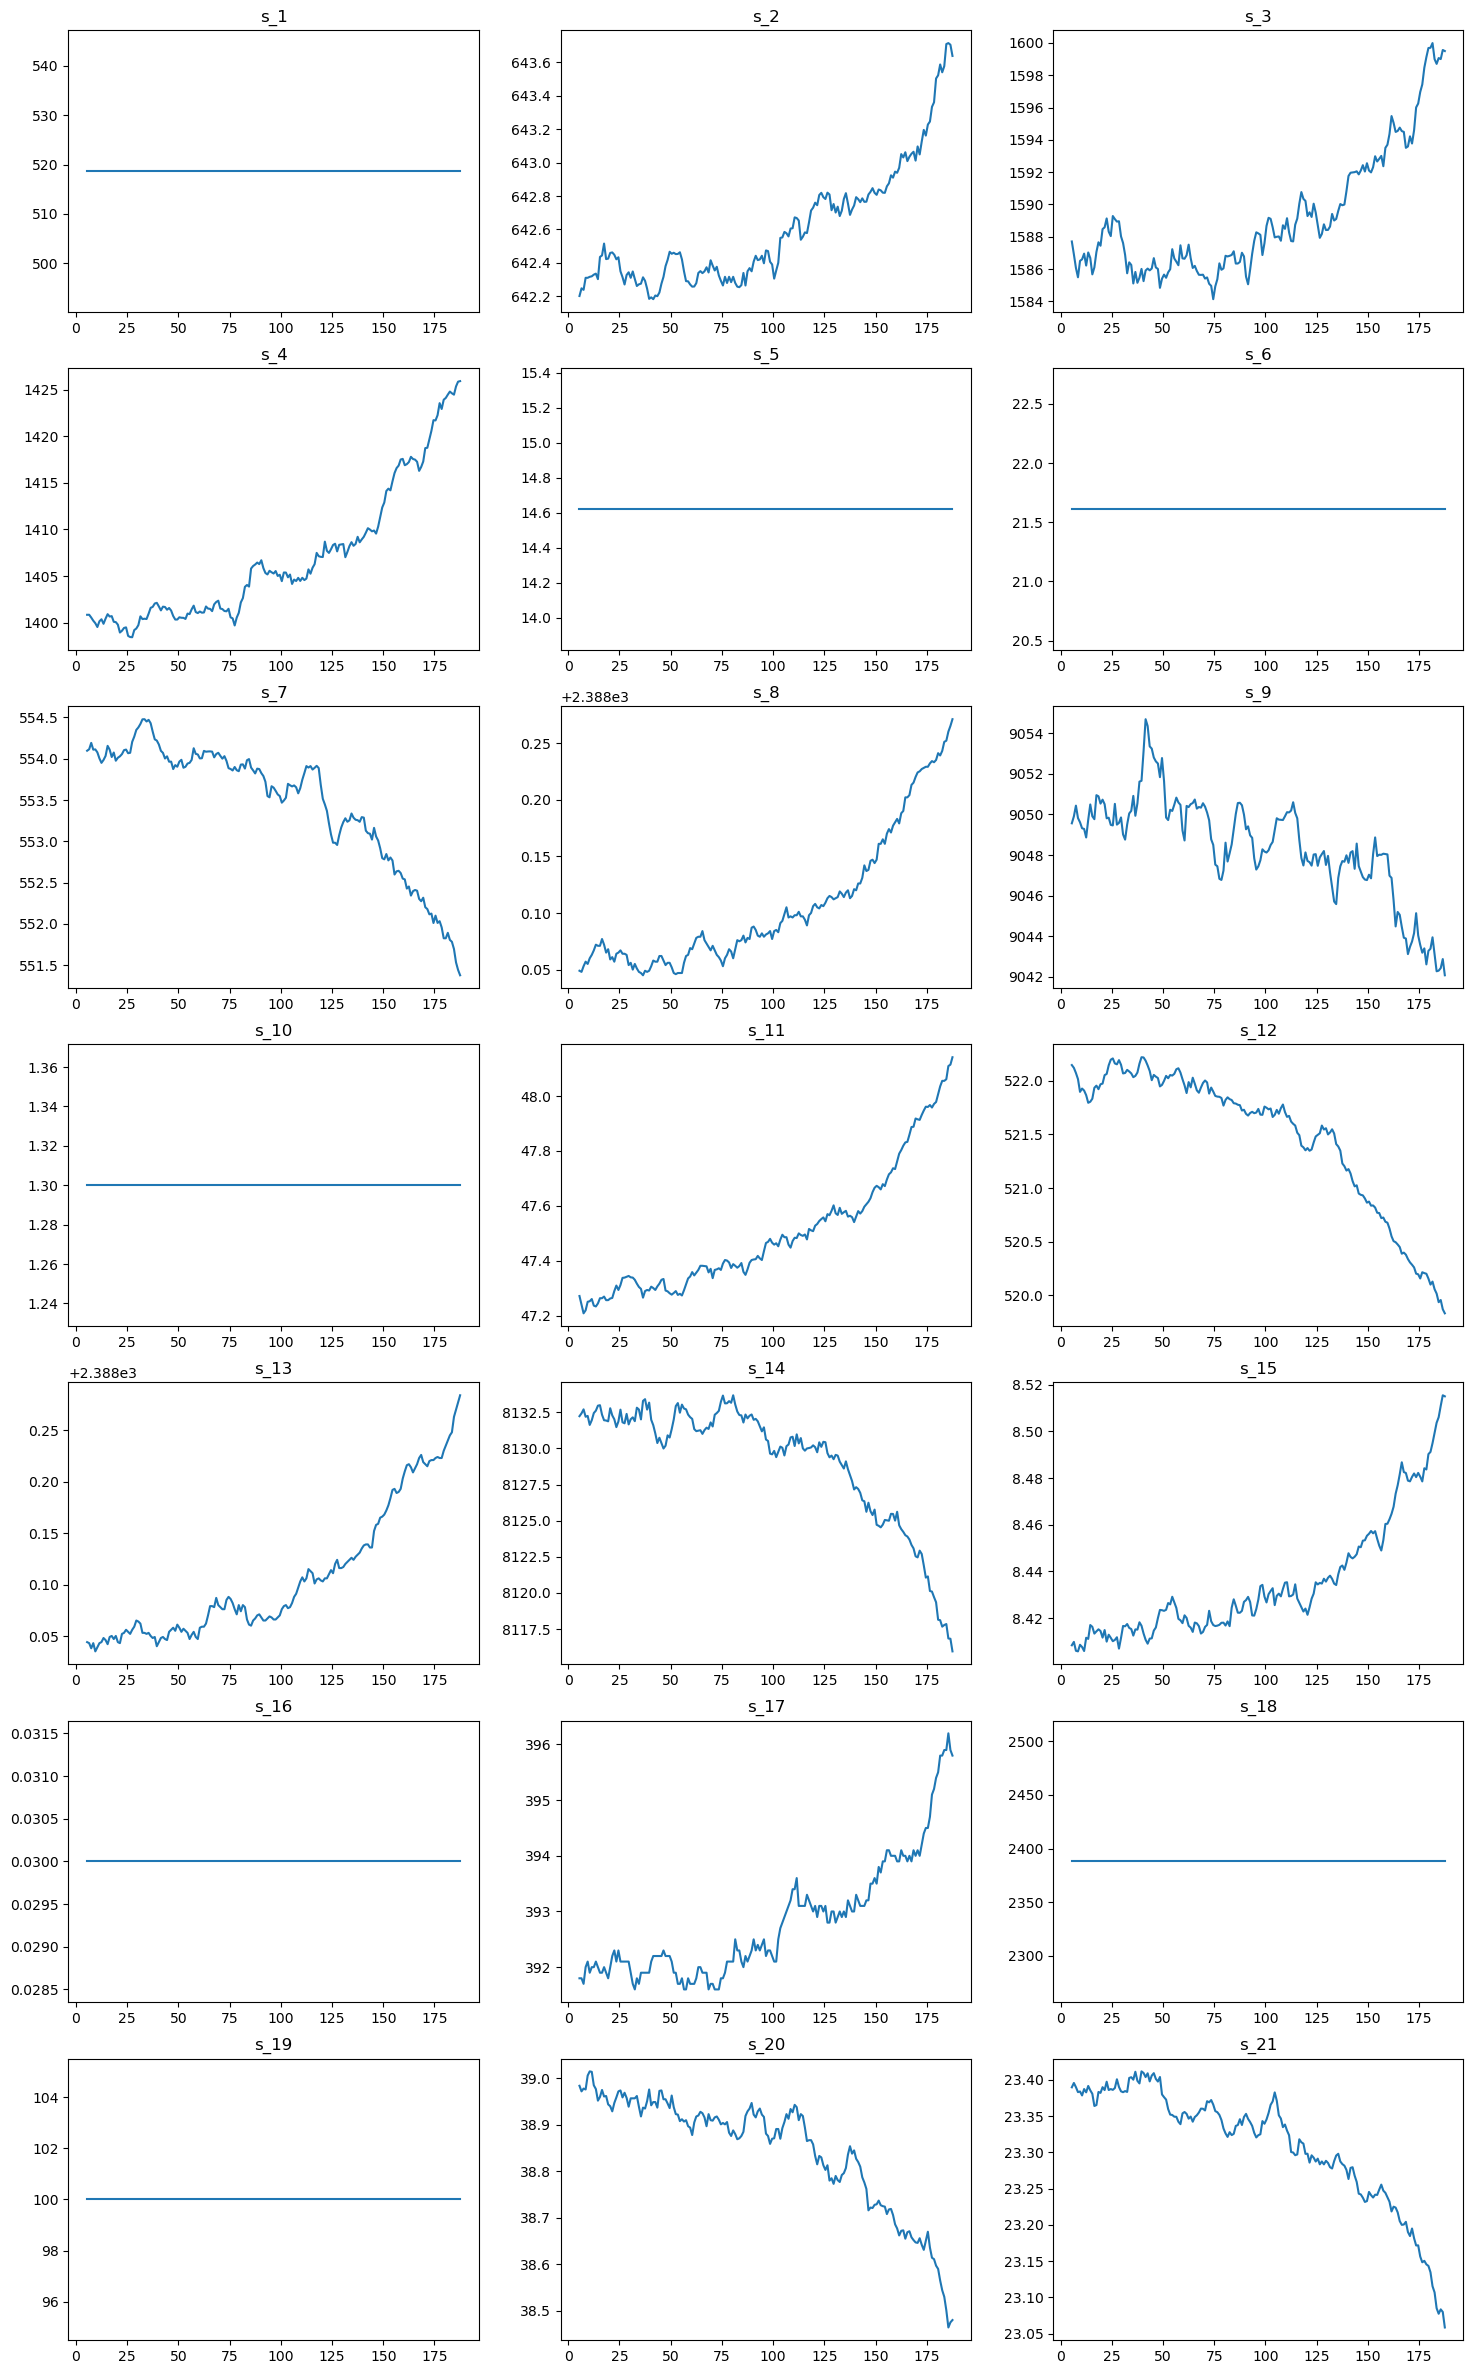

In [150]:
train_snesor_roll = train_sensor.rolling(10).mean()
show_sensor_traj(train_snesor_roll)

이 데이터셋도 데이터가 급격하게 변하네...
원래 보통데이터가 다 이런것 같기도 하고...

PCA로 뽑아낸 변수의 trajectory 확인해보기

In [125]:
from sklearn.decomposition import PCA

In [132]:
def Normalize(dataframe):
    gen = MinMaxScaler(feature_range=(0, 1))
    gen_data = gen.fit_transform(dataframe)
    return gen_data

def method_PCA(df, n_components=1):
    pca = PCA(n_components=n_components)
    data = pca.fit_transform(Normalize(df))
    return data

In [156]:
pca_df = train[train['unit_number']==1]
n_components = 10
train_snesor_roll_nan = train_snesor_roll.iloc[10:, :]
pca_data = method_PCA(pca_df, n_components = n_components)   # np: (192, n_components)

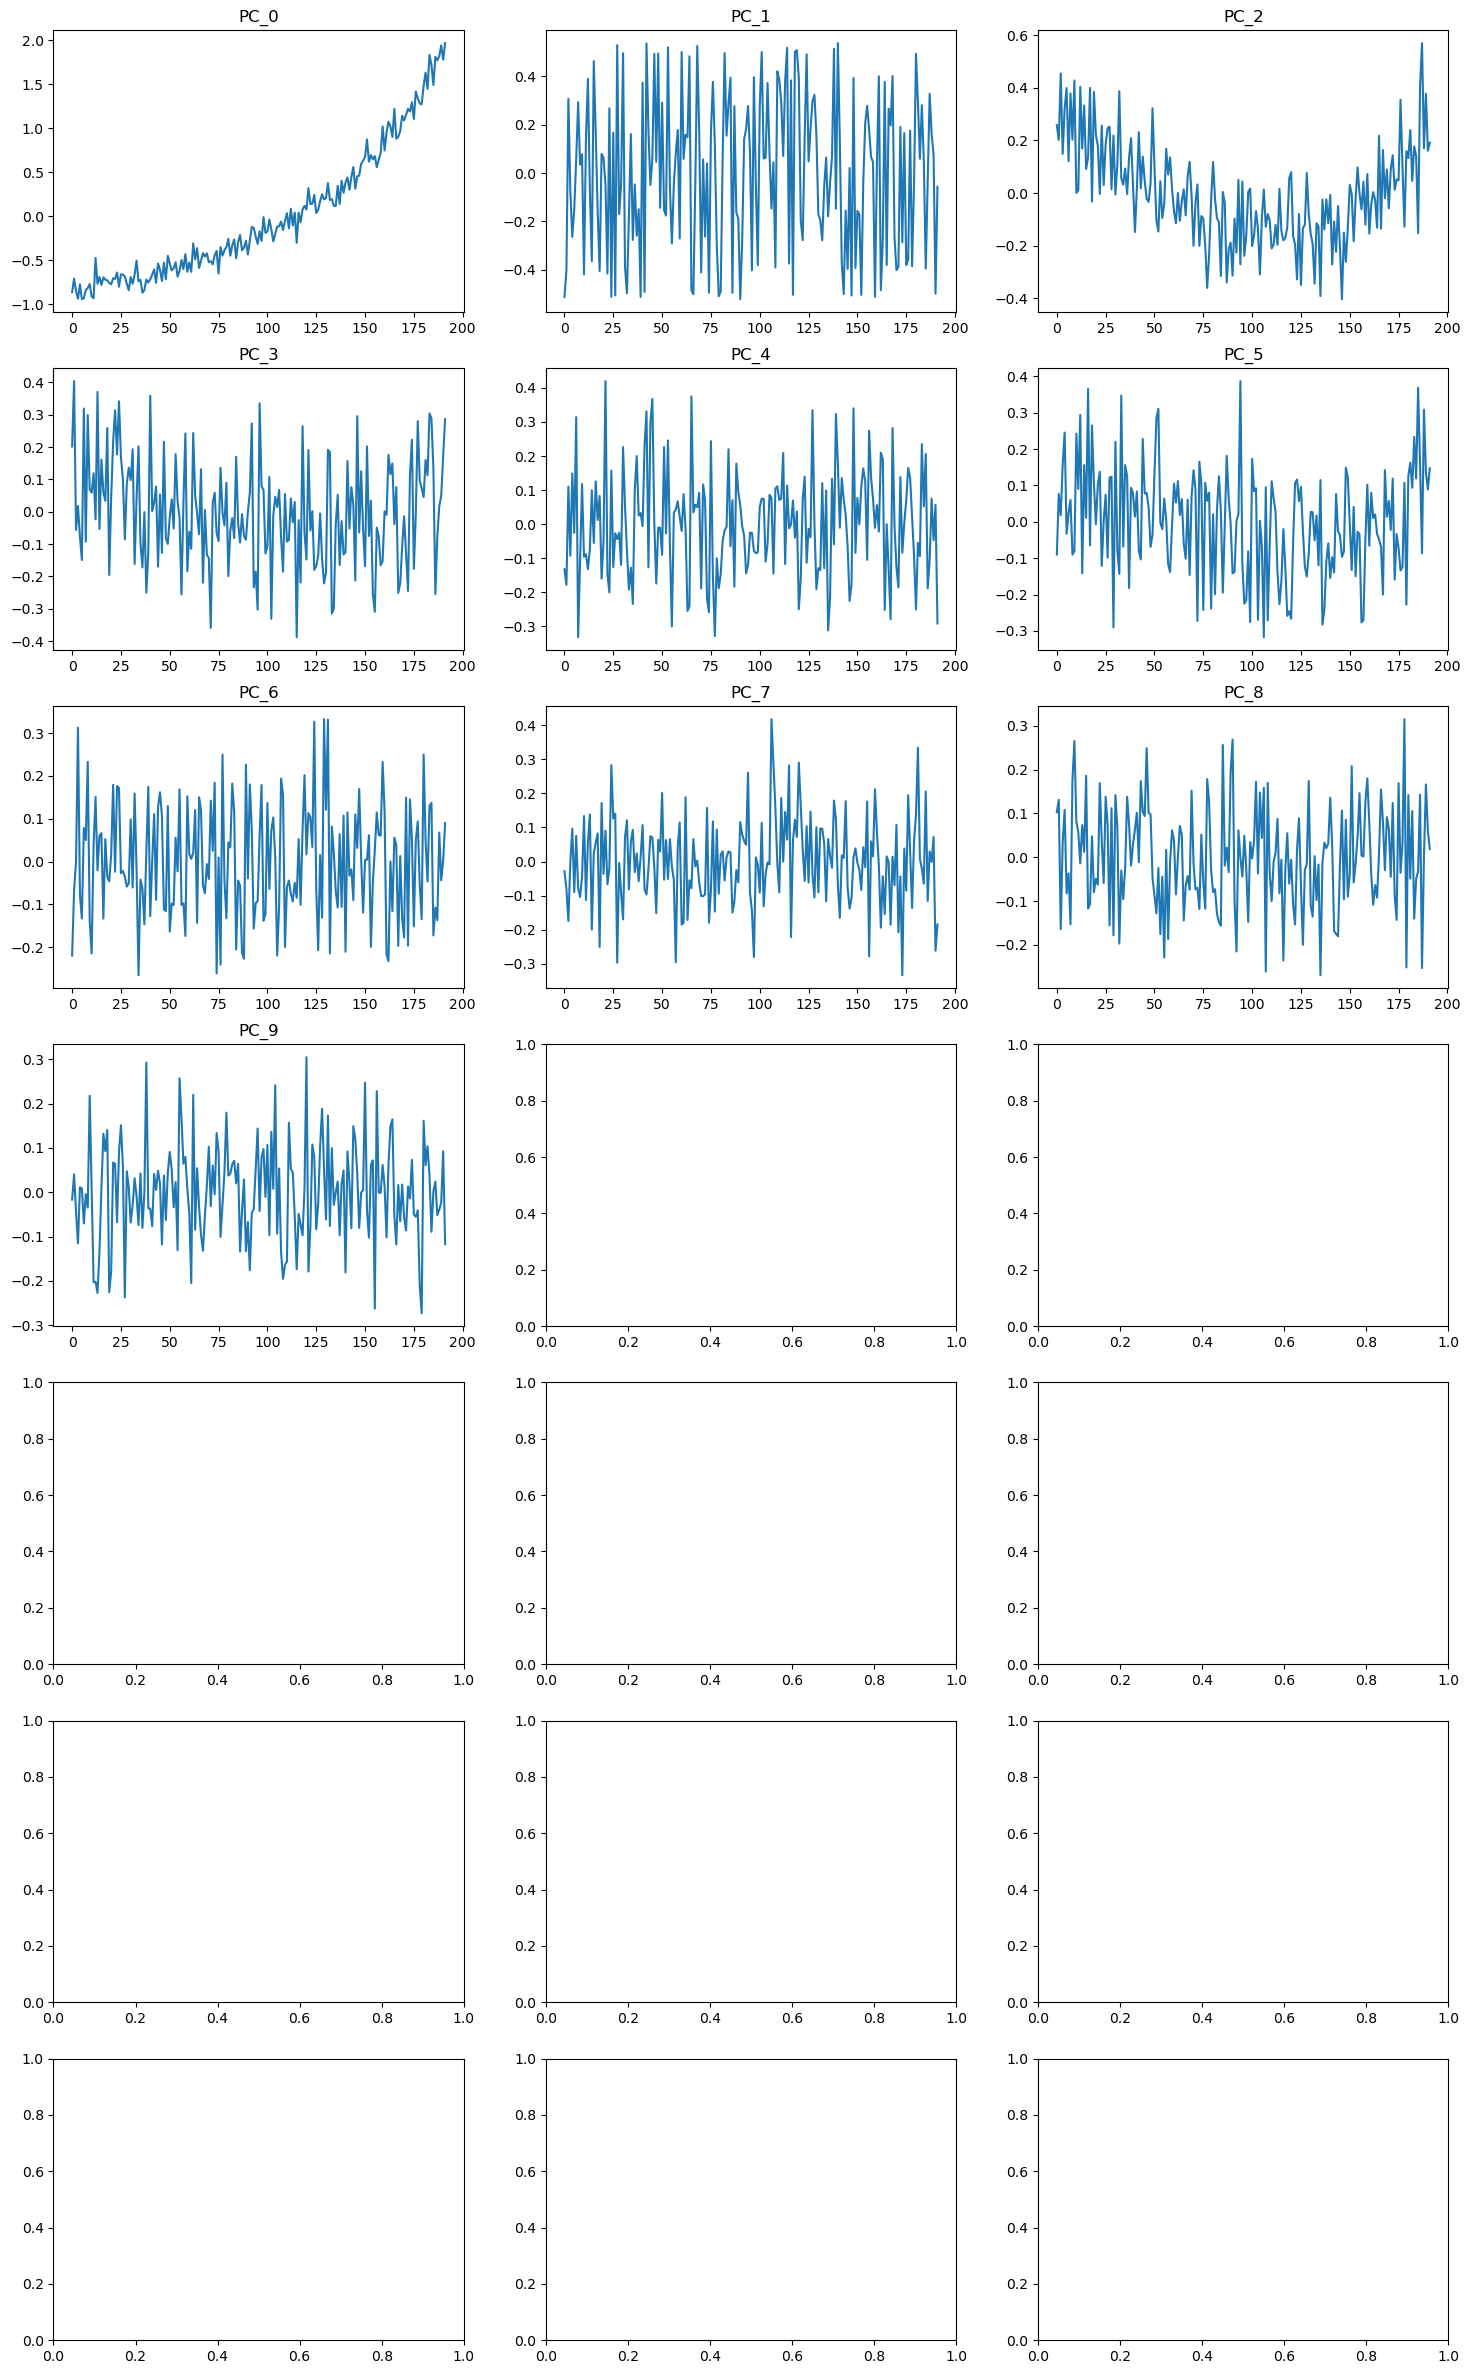

In [157]:
pca_data_df = pd.DataFrame(pca_data)

fig, axs = plt.subplots(7, 3,figsize=(18,30))
for i in range(pca_data_df.shape[1]):
    ax = axs.ravel()[i]
    ax.plot(pca_data_df.iloc[:, i])
    ax.set_title('PC_'+str(i))
    
plt.show()

Savitzky-Golay Filter 로 smoothing 

In [318]:
from scipy.signal import savgol_filter

window_length = 11
poly_order = 2

In [319]:
X_train_s_df = pd.DataFrame(X_train_s, columns=sensor_names)
X_train_scal_smoot_df = X_train_s_df.apply(lambda col: savgol_filter(col, window_length, poly_order))
X_train_scal_smoot = X_train_scal_smoot_df.values
print(X_train_scal_smoot_df.shape)
print(X_train_scal_smoot.shape)

(20631, 21)
(20631, 21)


In [210]:


group_train = train.groupby('unit_number')

def apply_savgol(group):
    group[sensor_names] = group[sensor_names].apply(lambda col: savgol_filter(col, window_length, poly_order))
    return group

smooth_groups = [apply_savgol(group) for name, group in group_train]
smooth_train_df = pd.concat(smooth_groups, ignore_index=True)


# print(smooth_train_df.iloc[10:15, 6:8])
# print(train.iloc[10:15, 6:8])
    


Check smooth trajectory

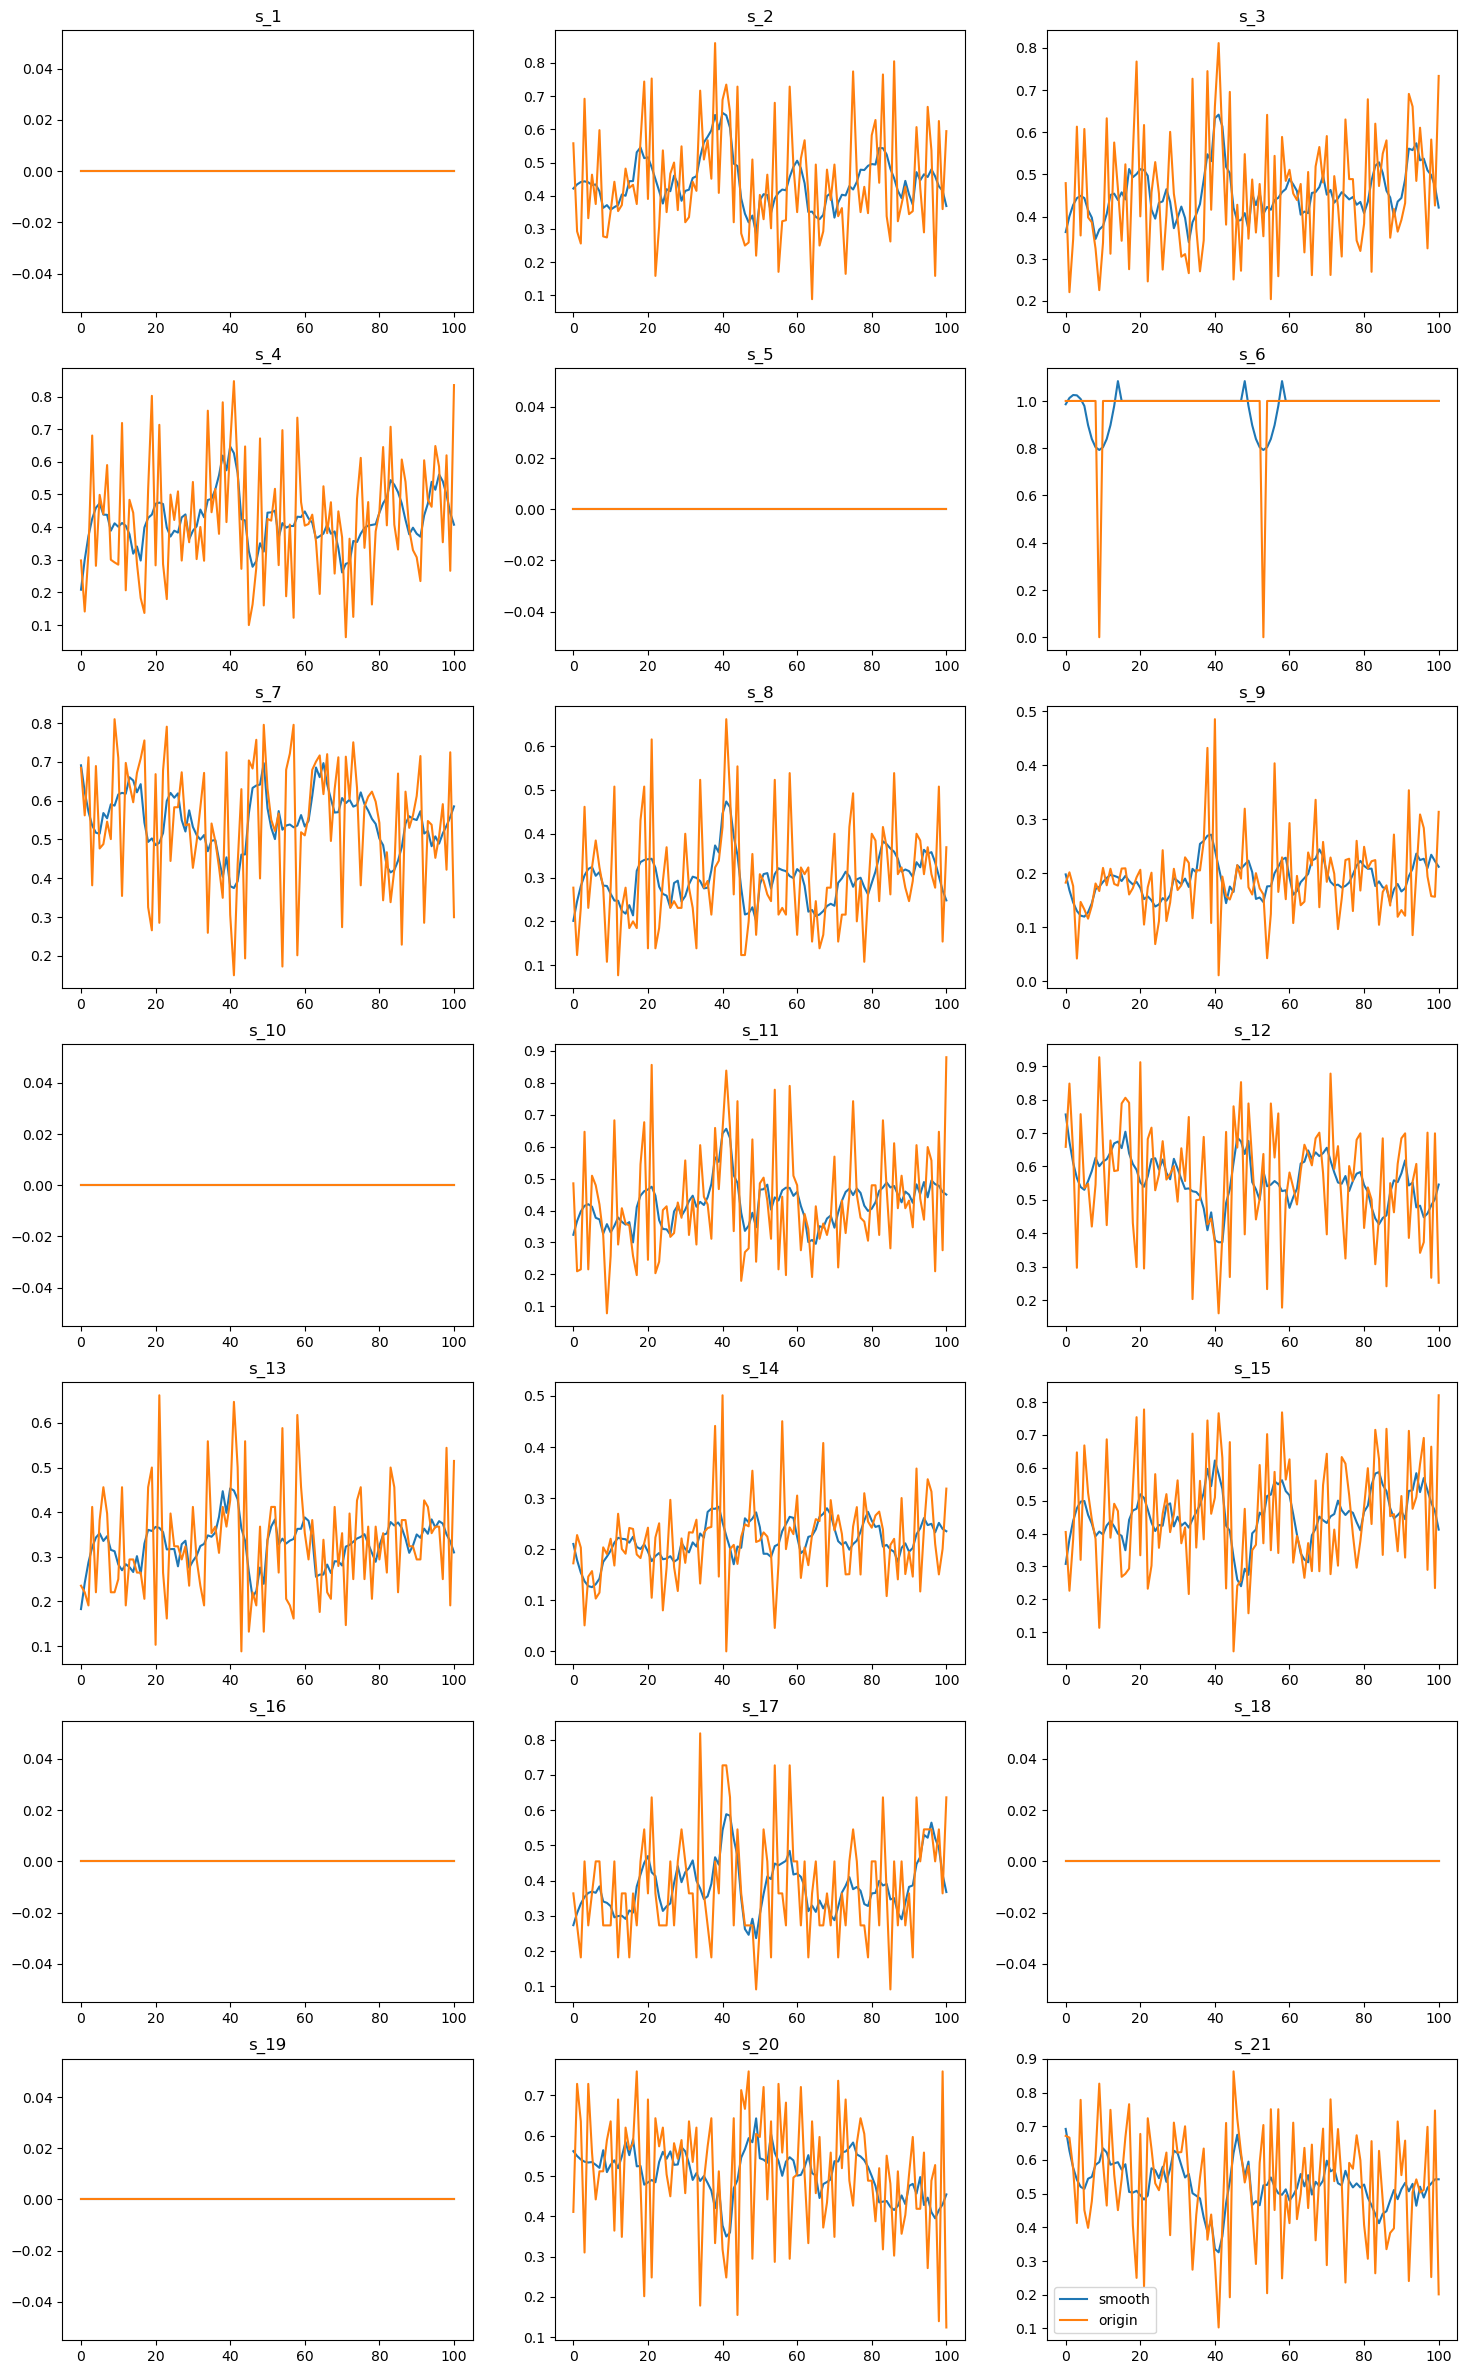

In [271]:
# train_unit = train[train['unit_number']==2]
# train_unit_sensor = train_unit[sensor_names]

# smooth_train_unit = smooth_train_df[smooth_train_df['unit_number']==2]
# smooth_train_unit_sensor = smooth_train_unit[sensor_names]



# figure

fig, axs = plt.subplots(7, 3,figsize=(18,30))
for i in range(len(sensor_names)):
    ax = axs.ravel()[i]
    ax.plot(X_train_scal_smoot_df.loc[:100, 's_'+str(i+1)], label='smooth')
    ax.plot(X_train_s_df.loc[:100, 's_'+str(i+1)], label='origin')
    ax.set_title(sensor_names[i])
    
plt.legend()
plt.show()

# print(smooth_train_unit_sensor.head())

# Network

In [285]:
class Encoder(nn.Module):
    def __init__(self, input_size,latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_size,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,32)
        self.fc4 = nn.Linear(32,latent_dim)
        self.initialize_weights()

    def initialize_weights(self):
        for m in self.modules():
            print(m)
            if isinstance(m, nn.Linear):
                #nn.init.xavier_normal_(m.weight) #per la sigmoid
                nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))   
        x = torch.relu(self.fc4(x))
        return x 

class Decoder(nn.Module):
    def __init__(self, input_size,latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim,32)
        self.fc2 = nn.Linear(32,64)
        self.fc3 = nn.Linear(64,128)
        self.fc4 = nn.Linear(128,input_size)
        self.initialize_weights()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))   
        x = torch.relu(self.fc4(x))
        return x

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                #nn.init.xavier_normal_(m.weight)
                nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.1)

class Autoencoder(nn.Module):
    def __init__(self, input_size, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_size,latent_dim)
        self.decoder = Decoder(input_size,latent_dim)
        self.SINDyLibrary = SINDyLibrary(
            device=device,
            latent_dim=latent_dim,
            include_biases=False,
            include_states=True,
            include_sin=True,
            include_cos=False,
            include_multiply_pairs=False, #non ho capito cosa é ma conta due volte le coppie  
            poly_order=1,
            include_sqrt=False,
            include_inverse=False,
            include_sign_sqrt_of_diff=False)
        

        self.XI = nn.Parameter(torch.full((self.SINDyLibrary.number_candidate_functions,latent_dim),1.,dtype = torch.float32,requires_grad=True,device = device))
#        self.XI = nn.Parameter(torch.randn((self.SINDyLibrary.number_candidate_functions,latent_dim),
        self.XI_coefficient_mask = torch.ones((self.SINDyLibrary.number_candidate_functions,latent_dim),dtype = torch.float32, device=device)

    def configure_optimizers(self):
        learning_rate = 1e-4
        return torch.optim.SGD(self.parameters(), lr=learning_rate, momentum = 0.9)
        #return torch.optim.Adam(self.parameters(), lr=learning_rate)


    def t_derivative(self,input, xdot, weights, biases, activation='sigmoid'):
        """
        Compute the first order time derivatives by propagating through the network.
        da[l]dt = xdot * da[l]dx = xdot * product(g'(w[l]a[l-1] + b[l])* w[l])
        Arguments:
            input - 2D tensorflow array, input to the network. Dimensions are number of time points
            by number of state variables.
            xdot - First order time derivatives of the input to the network. quello che conosciamo
            weights - List of tensorflow arrays containing the network weights
            biases - List of tensorflow arrays containing the network biases
            activation - String specifying which activation function to use. Options are
            'elu' (exponential linear unit), 'relu' (rectified linear unit), 'sigmoid',
            or linear.

        Returns:
            dadt - Tensorflow array, first order time derivatives of the network output.
        """
        a   = input
        dadt = xdot #per le condizioni iniziali

        if activation == 'sigmoid':
            for i in range(len(weights) - 1):
                z = torch.matmul(a, weights[i].T) + biases[i]
                a = torch.sigmoid(z)
                gprime = a * (1-a)
                dadt = gprime * torch.matmul(dadt, weights[i].T)
            dadt = torch.matmul(dadt, weights[-1].T) #fuori dal ciclo bisogna ancora moltiplicare per i pesi dell ultimo livello
            
        elif activation == 'relu':
            for i in range(len(weights) - 1):
                z = torch.matmul(a, weights[i].T) + biases[i]
                a = torch.relu(z)
                dadt = (z > 0).float() * torch.matmul(dadt, weights[i].T)    
            dadt = torch.matmul(dadt, weights[-1].T) #fuori dal ciclo bisogna ancora moltiplicare per i pesi dell ultimo livello
        return dadt #nel caso che ci serve dadt sará l output dell encoder ossia le latent variables!

    
    
    def compute_quantities(self,x,xdot):
    
        z = self.encoder(x)
        xtilde = self.decoder(z)

        theta = self.SINDyLibrary.transform(z) 
        zdot_hat = torch.matmul(theta, self.XI_coefficient_mask * self.XI)
        
        encoder_parameters = list(self.encoder.parameters())
        encoder_weight_list = [w for w in encoder_parameters if len(w.shape) == 2]
        encoder_biases_list = [b for b in encoder_parameters if len(b.shape) == 1]
        zdot = self.t_derivative(x, xdot, encoder_weight_list, encoder_biases_list, activation='relu')                                               

        #print("propagazione sul decoder")
        decoder_parameters = list(self.decoder.parameters())
        decoder_weight_list = [w for w in decoder_parameters if len(w.shape) == 2]
        decoder_biases_list = [b for b in decoder_parameters if len(b.shape) == 1]
        xtildedot = self.t_derivative(z, zdot_hat, decoder_weight_list, decoder_biases_list, activation='relu')    
        
        return xtilde, xtildedot, z, zdot, zdot_hat

    def loss_function(self, x, xdot, xtilde, xtildedot, zdot, zdot_hat,XI):
        mse = nn.MSELoss()
        alpha1 = 5e-4
        alpha2 = 5e-5
        alpha3 = 1e-5


        loss = {}
        loss['recon_loss'] = mse(x, xtilde) #errore di ricostruzione 
        loss ['sindy_loss_x'] = mse(xdot, xtildedot) 
        loss ['sindy_loss_z'] = mse(zdot, zdot_hat) 
        loss['sindy_regular_loss'] = torch.sum(torch.abs(XI)) #norma L1 degli XI
        loss['tot'] = loss['recon_loss'] + alpha1*loss['sindy_loss_x'] + alpha2*loss['sindy_loss_z'] + alpha3*loss['sindy_regular_loss']
        tot = loss['tot']
        return tot, loss
    
    def forward(self, x, xdot):
        return self.compute_quantities(x, xdot)

Smooth data 가지고 time derivative 계산


In [292]:
def generate_list_increasing_by_dt(size, dt=0.1):
    output_list = []
    current_value = 0

    for _ in range(size):
        output_list.append(current_value)
        current_value += dt

    return np.array(output_list)


In [320]:
differentiation_method = ps.FiniteDifference(order=2)

# differentiation_method._differentiate(X, t)
t_max = X_train_scal_smoot.shape[0]
t = generate_list_increasing_by_dt(size=t_max, dt=1)
Xdot = differentiation_method._differentiate(X_train_scal_smoot, t)
print(type(Xdot))

<class 'numpy.ndarray'>


Train SINDy-autoencoder


In [321]:
input_size = X_train_scal_smoot.shape[1]
latent_dim = 10

model = Autoencoder(input_size,latent_dim).to(device)

Encoder(
  (fc1): Linear(in_features=21, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)
Linear(in_features=21, out_features=128, bias=True)
Linear(in_features=128, out_features=64, bias=True)
Linear(in_features=64, out_features=32, bias=True)
Linear(in_features=32, out_features=10, bias=True)


In [322]:
X_ts = torch.from_numpy(X_train_scal_smoot).float().to(device)
Xdot_ts = torch.from_numpy(Xdot).float().to(device)

train_subset = TensorDataset(X_ts,Xdot_ts)

batch_size = 100
train_loader = DataLoader(train_subset, shuffle=False, batch_size=batch_size)
# valid_loader

In [337]:
# Define a custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.unit_numbers = dataframe['unit_number'].unique()

    def __len__(self):
        return len(self.unit_numbers)

    def __getitem__(self, idx):
        unit_number = self.unit_numbers[idx]
        unit_data = self.dataframe[self.dataframe['unit_number'] == unit_number]
        return unit_data

# Create a DataLoader that shuffles data per 'unit_number'
def collate_fn(batch):
    print(batch)
    return pd.concat(batch).sample(frac=1)

custom_dataset = CustomDataset(train)
custom_dataloader = DataLoader(custom_dataset, batch_size=1, shuffle=False)

# print(train)
# Iterate through the DataLoader
for batch in custom_dataloader:
    print(batch)

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'pandas.core.frame.DataFrame'>

In [341]:
class UnitNumberDataset(Dataset):
    def __init__(self, df):
        self.groups = [group for _, group in df.groupby('unit_number')]

    def __getitem__(self, index):
        group = self.groups[index]
        time_series_data = group.values
        return torch.tensor(time_series_data, dtype=torch.float)

    def __len__(self):
        return len(self.groups)

custom_dataset = UnitNumberDataset(train)
custom_dataloader = DataLoader(custom_dataset, batch_size=1)

for batch in custom_dataloader: # batch size: [batch_size, time_cycles, # of states]
    print(batch.shape)

RuntimeError: stack expects each tensor to be equal size, but got [192, 27] at entry 0 and [287, 27] at entry 1